<a href="https://colab.research.google.com/github/Stewu44/Python_projects/blob/main/OptionTradingApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install py_vollib



  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 4.7 MB/s eta 0:00:00
  Created wheel for py_vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62831 sha256=7c2293b138606d85cdb0e6be56b0497e82a2833b1cf572ee3ef6d75c05ee4a15
  Stored in directory: /root/.cache/pip/wheels/84/0c/fc/b68506eda40cccaeb0013be550ba904d253ec90eae2b156052
  Created wheel for py_lets_be_rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24451 sha256=6b07cd48a12d67679d004e6546356f20e18e91c7e98103a94069d9e401ba7db0
  Stored in directory: /root/.cache/pip/wheels/32/d9/4f/360d4b0b9ec7c65583ec7c8e72fd2158c97ad04fbcb932891c
Successfully built py_vollib py_lets_be_rational


[*********************100%***********************]  1 of 1 completed


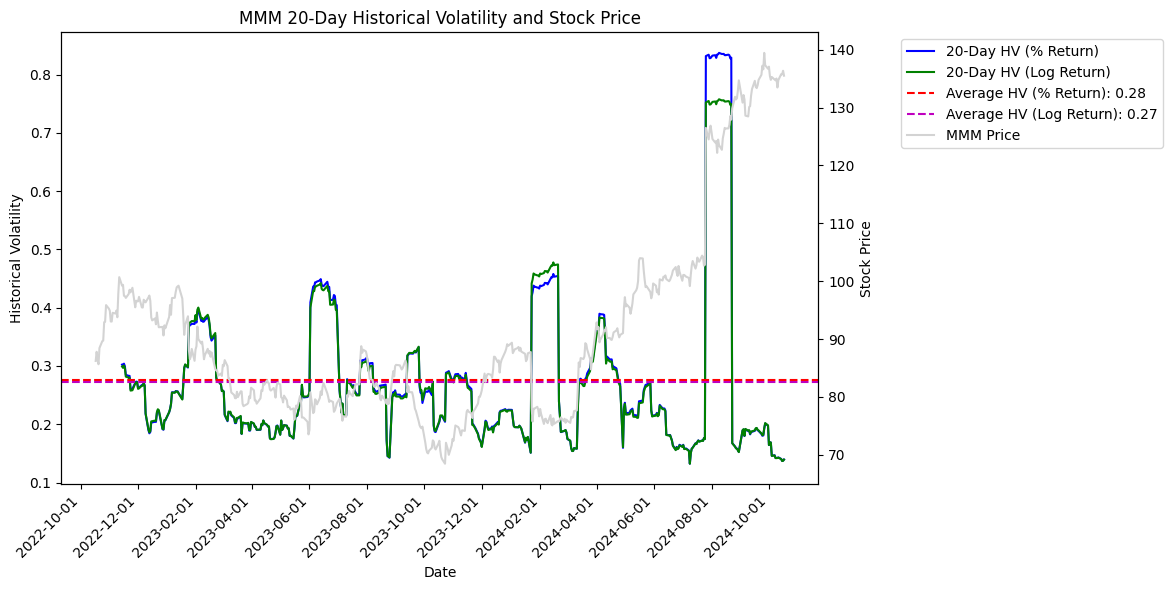

[*********************100%***********************]  1 of 1 completed


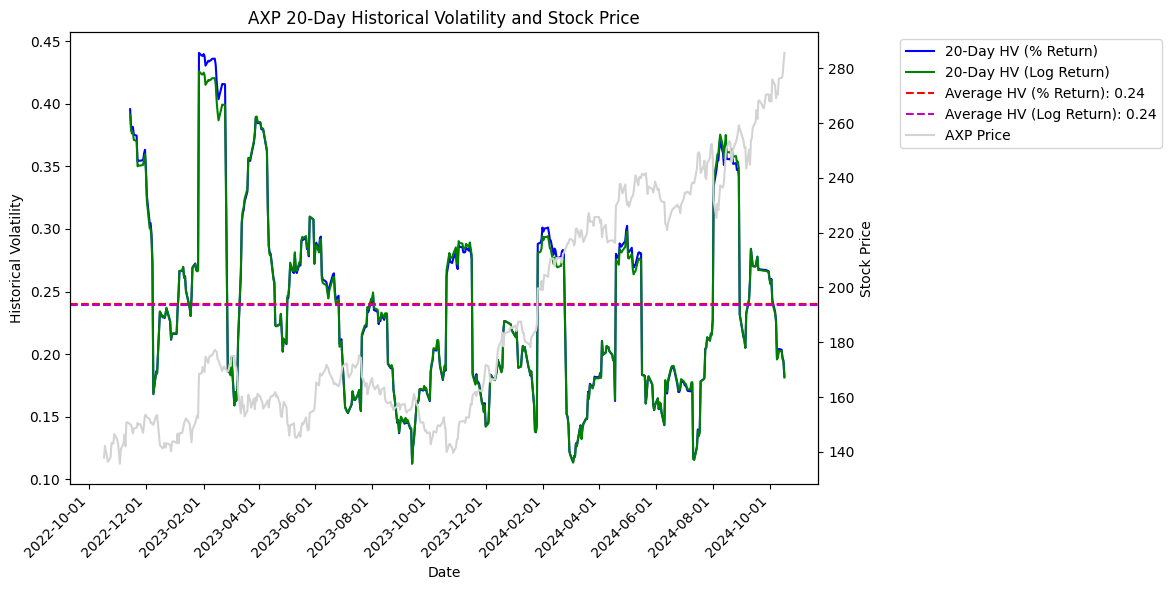

[*********************100%***********************]  1 of 1 completed


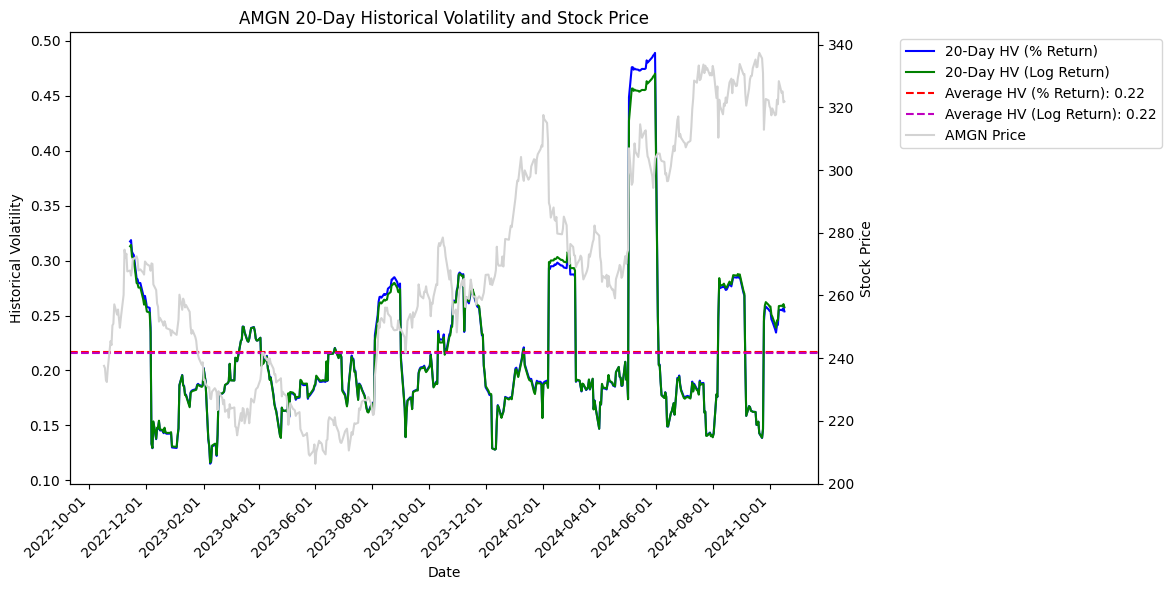

[*********************100%***********************]  1 of 1 completed


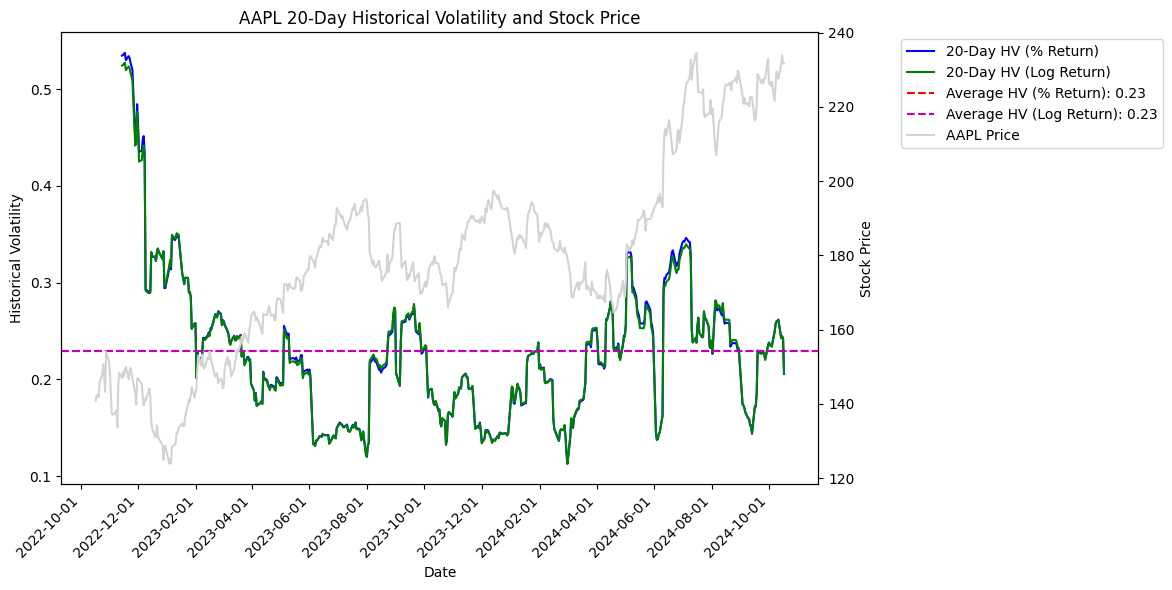

[*********************100%***********************]  1 of 1 completed


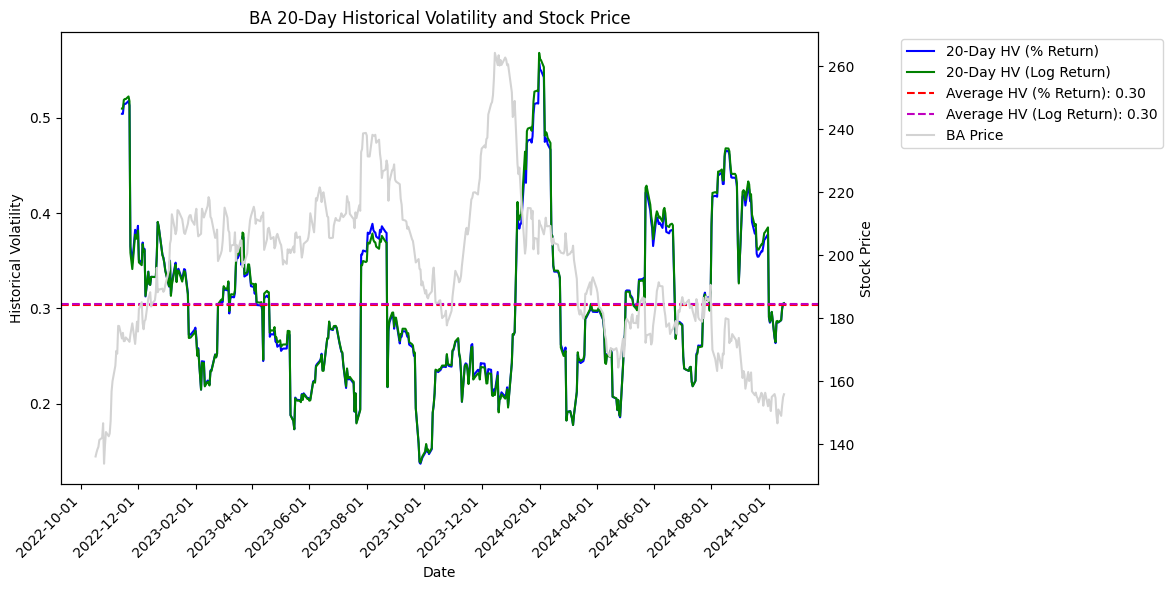

[*********************100%***********************]  1 of 1 completed


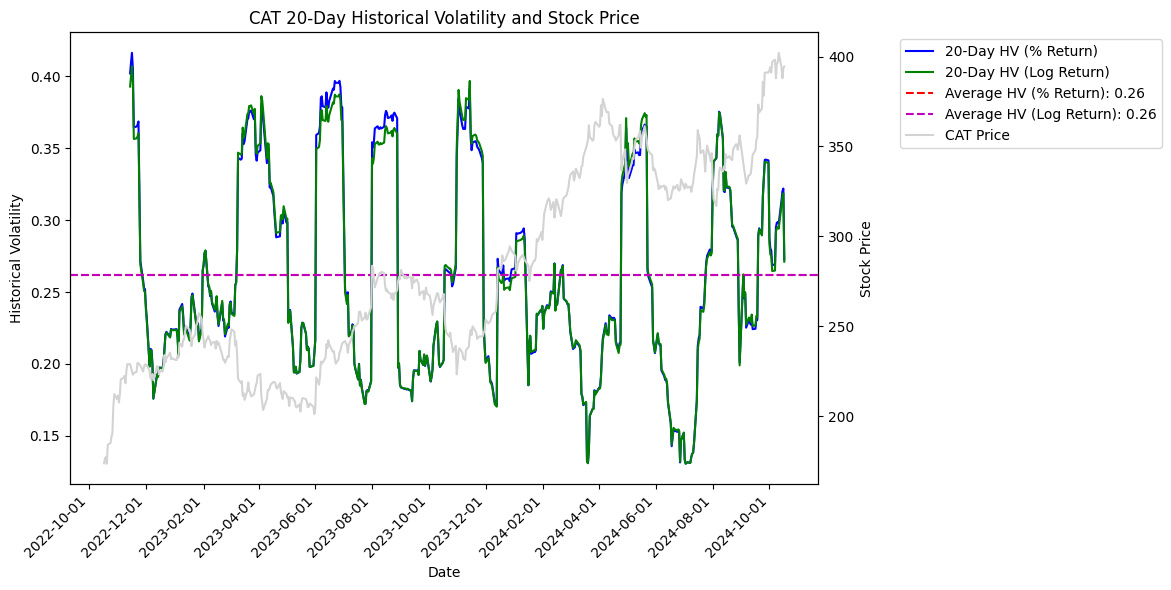

[*********************100%***********************]  1 of 1 completed


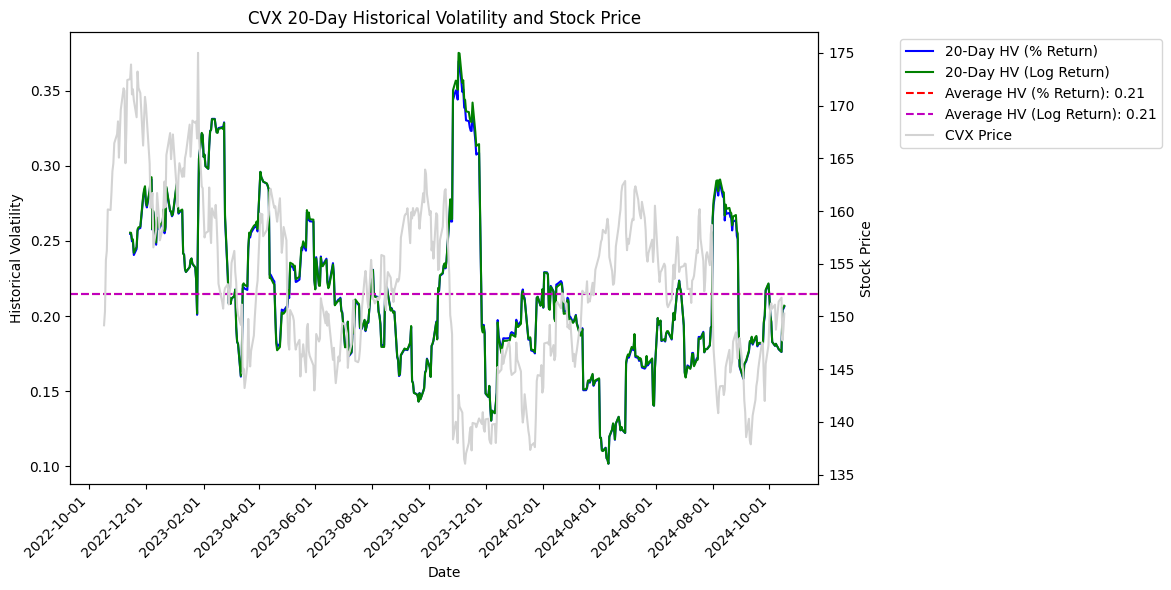

[*********************100%***********************]  1 of 1 completed


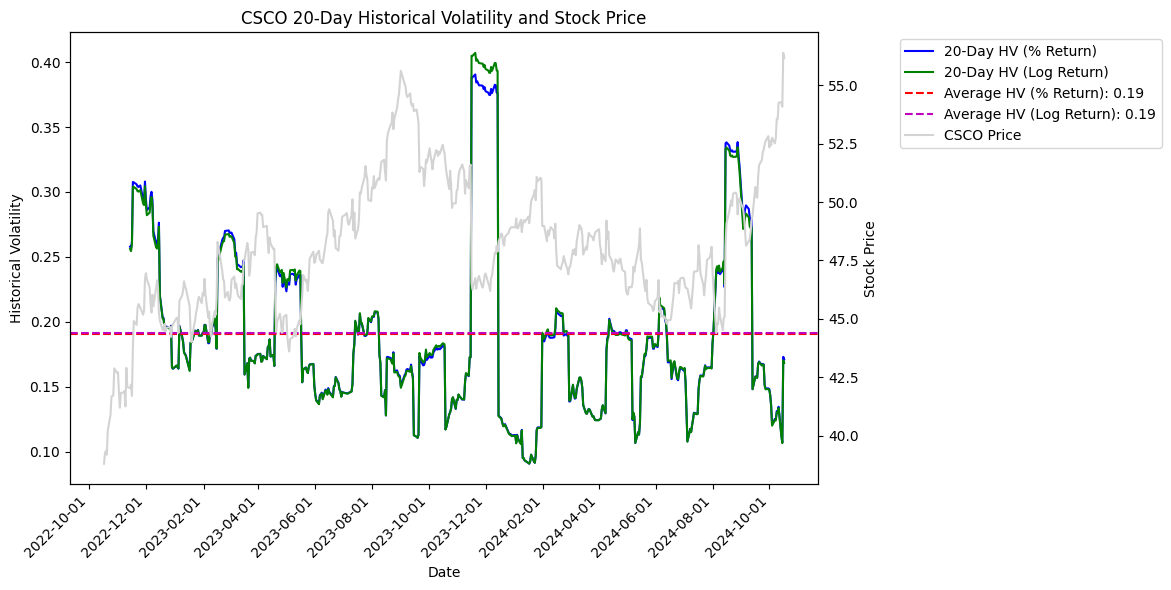

[*********************100%***********************]  1 of 1 completed


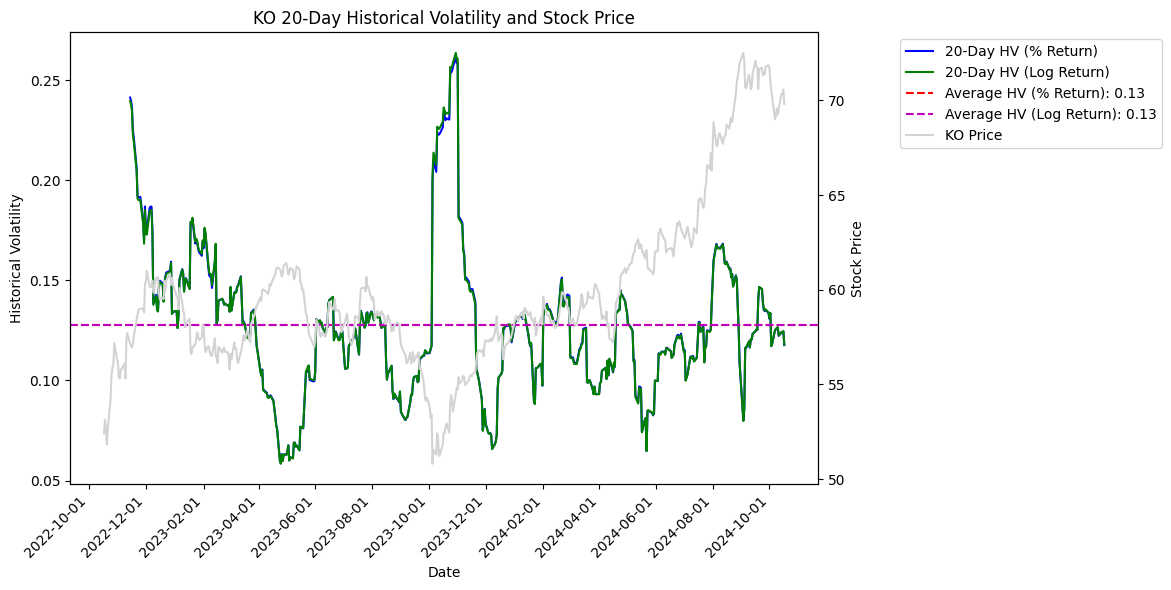

[*********************100%***********************]  1 of 1 completed


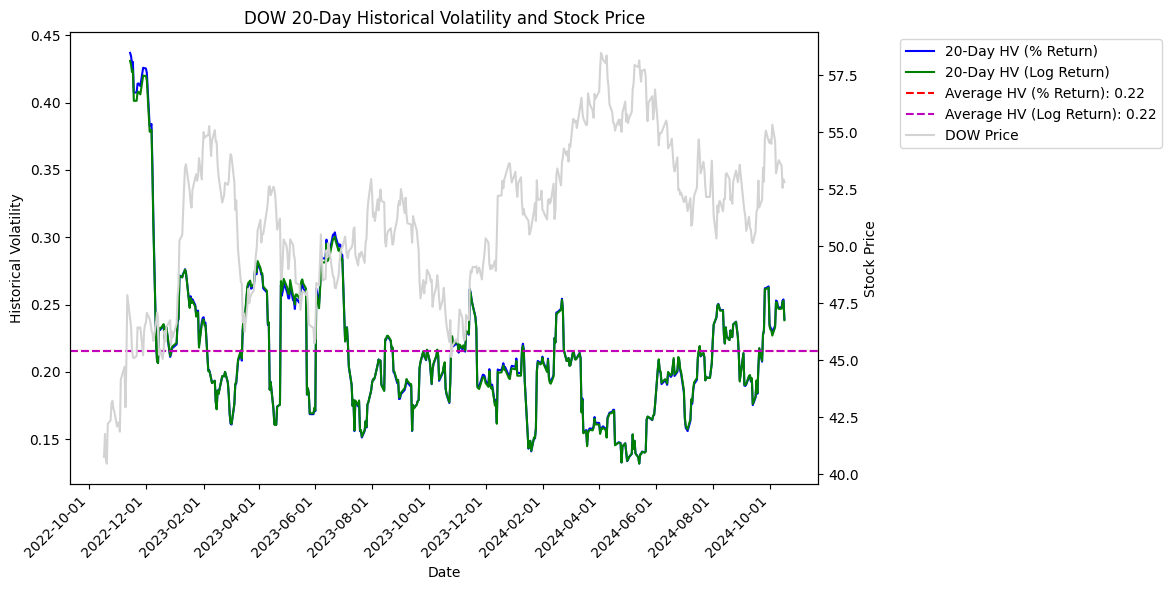

[*********************100%***********************]  1 of 1 completed


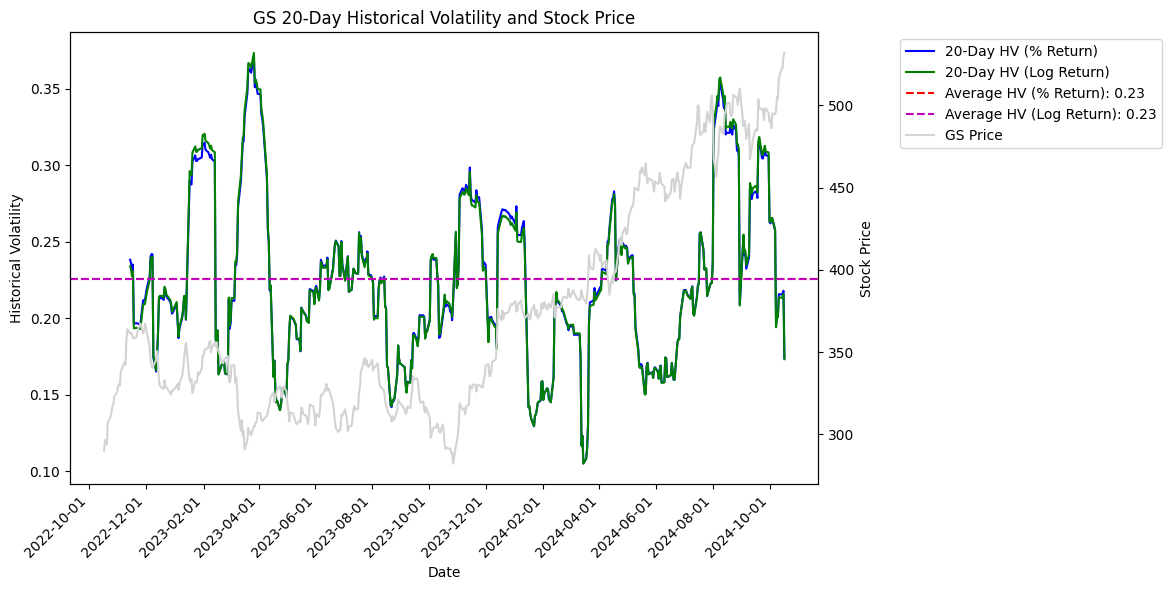

[*********************100%***********************]  1 of 1 completed


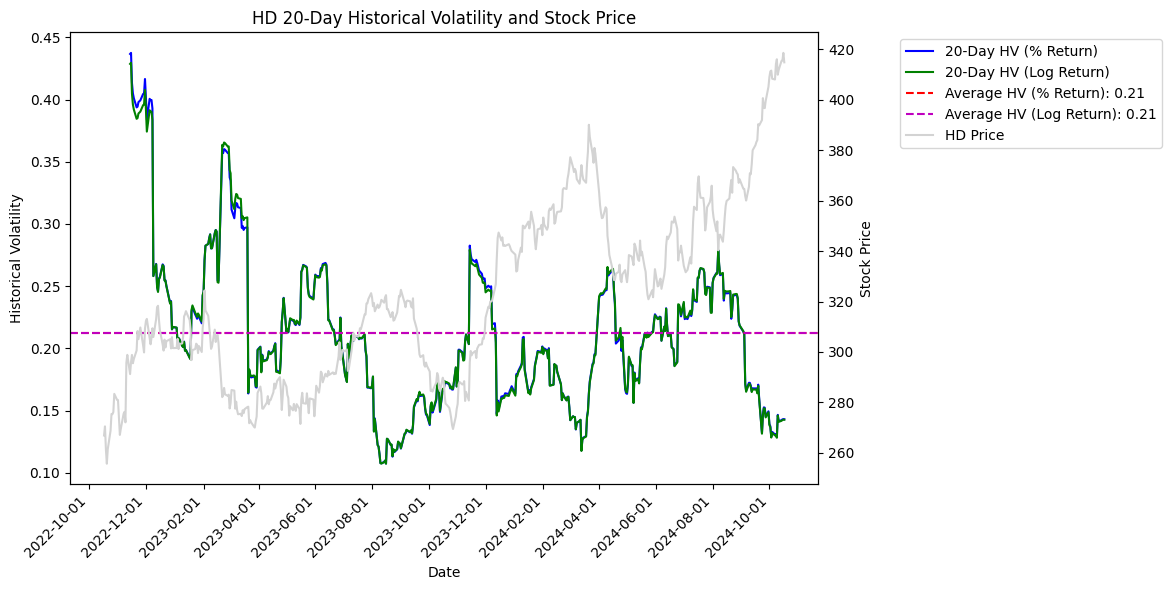

[*********************100%***********************]  1 of 1 completed


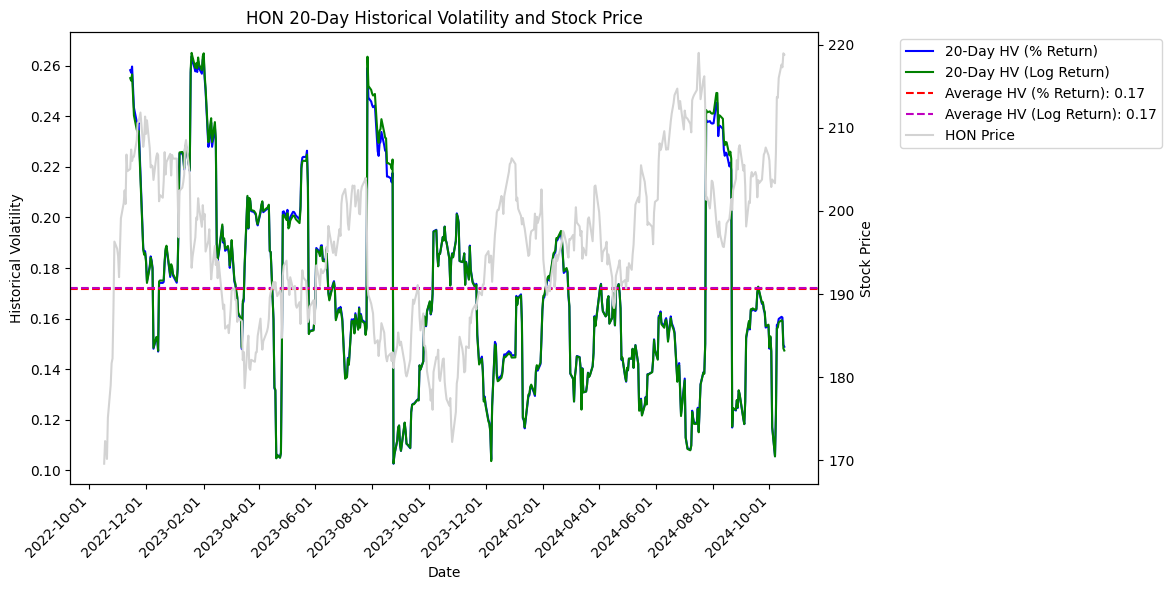

[*********************100%***********************]  1 of 1 completed


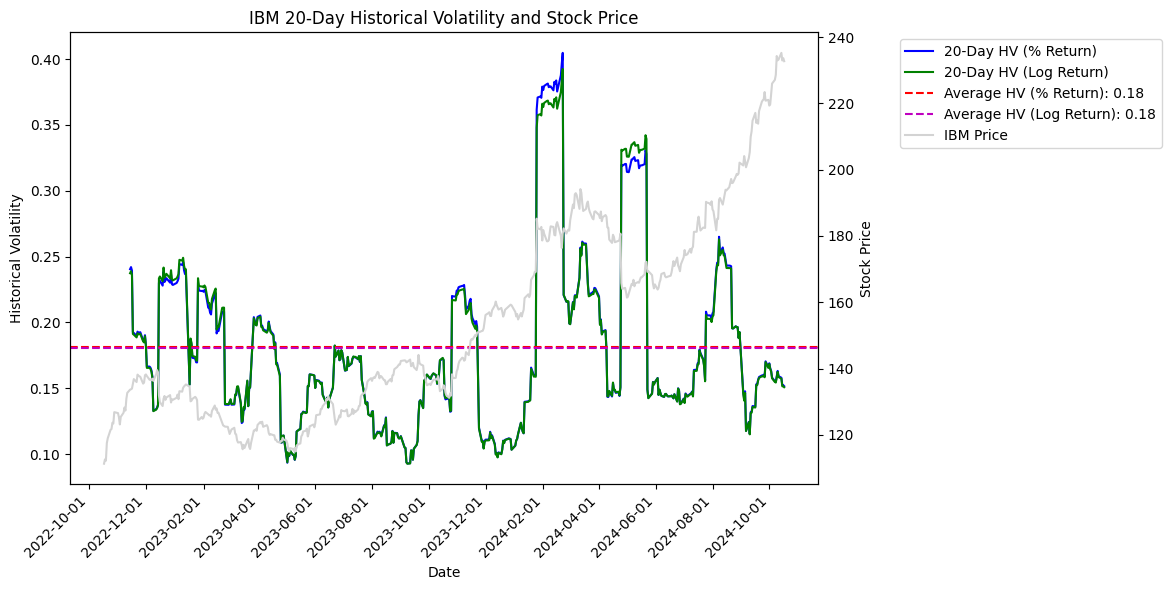

[*********************100%***********************]  1 of 1 completed


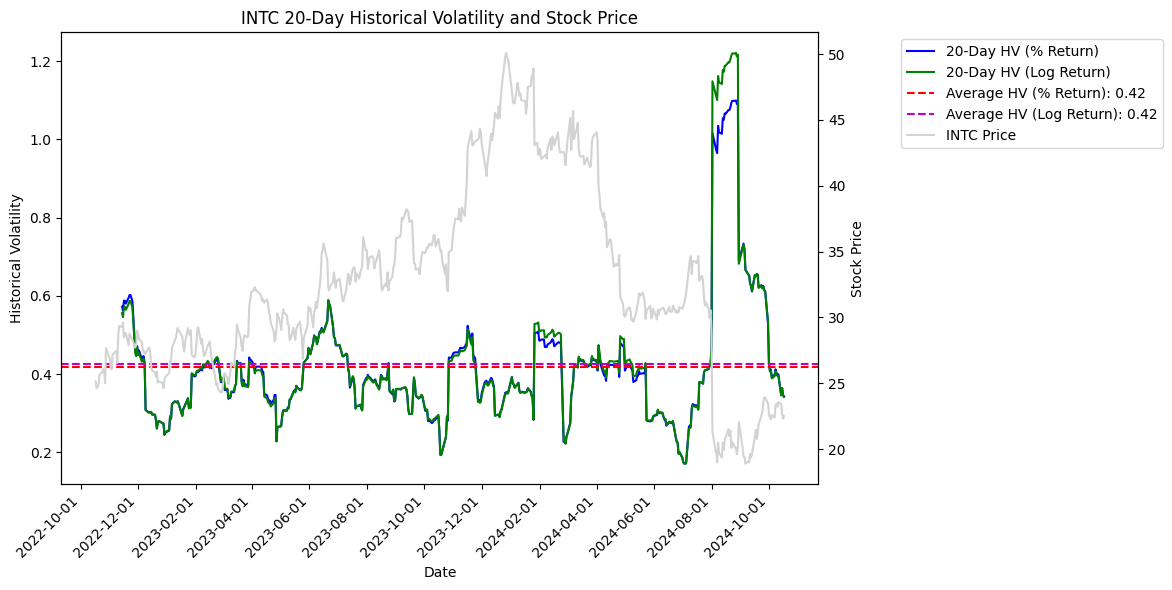

[*********************100%***********************]  1 of 1 completed


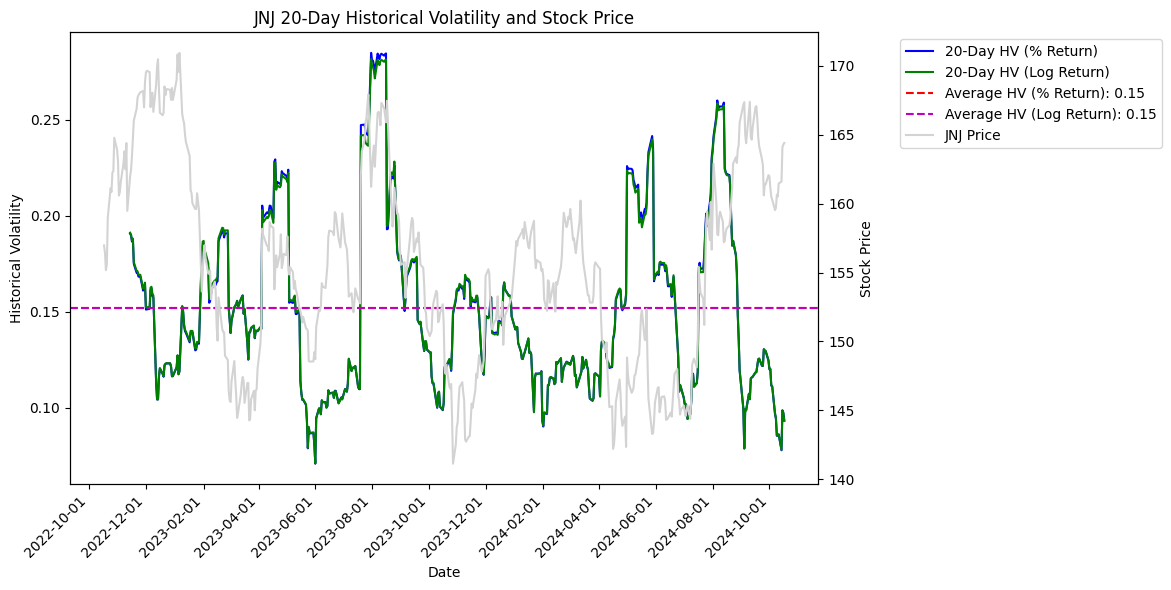

[*********************100%***********************]  1 of 1 completed


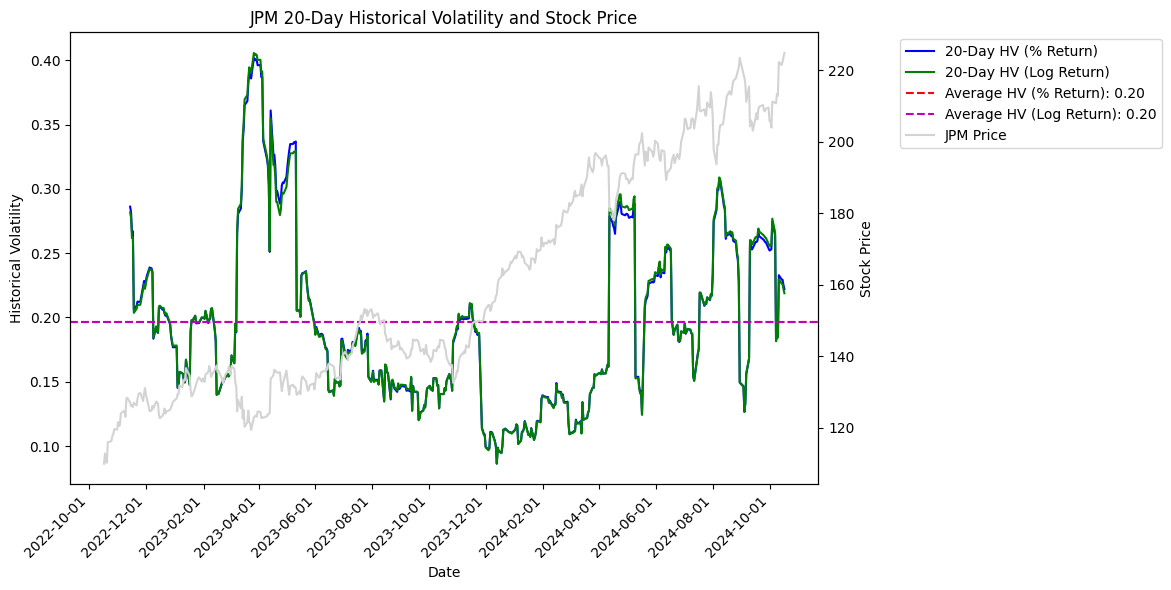

[*********************100%***********************]  1 of 1 completed


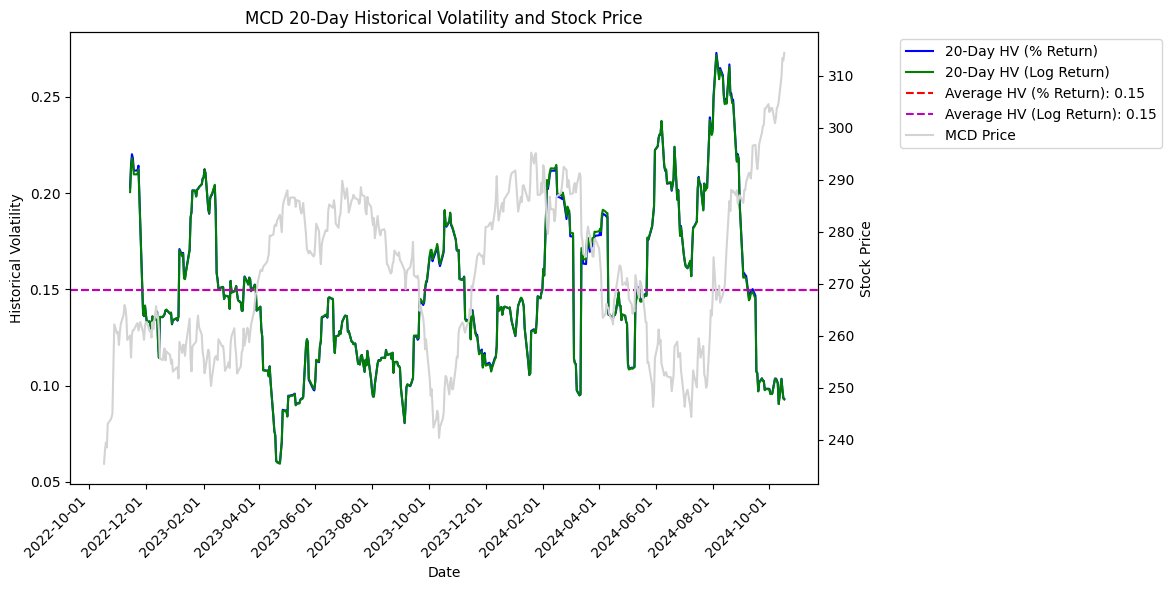

[*********************100%***********************]  1 of 1 completed


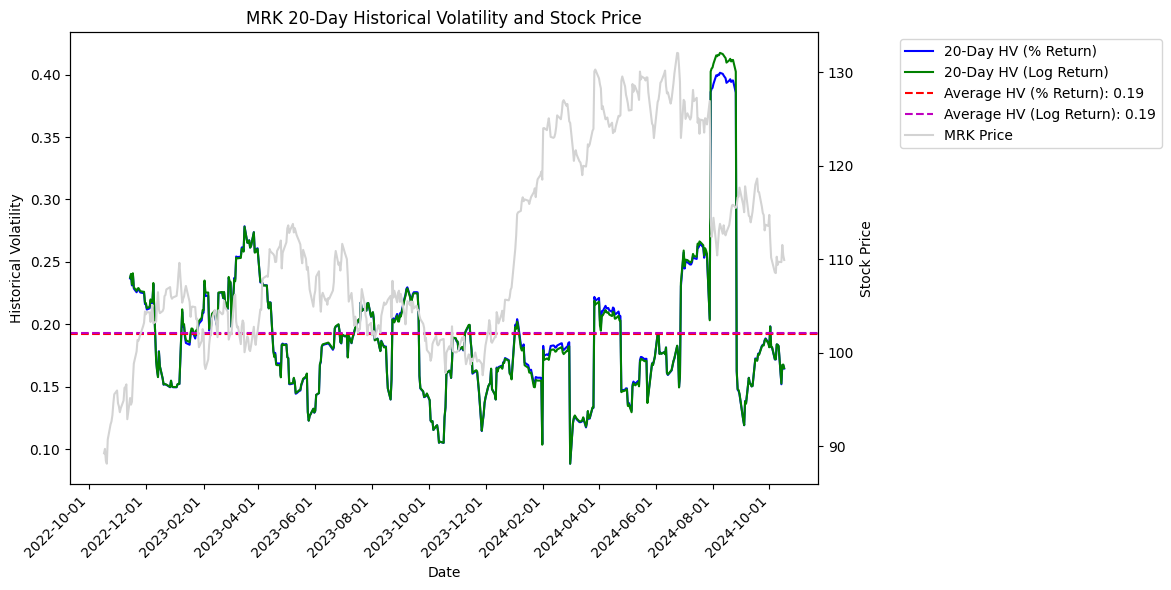

[*********************100%***********************]  1 of 1 completed


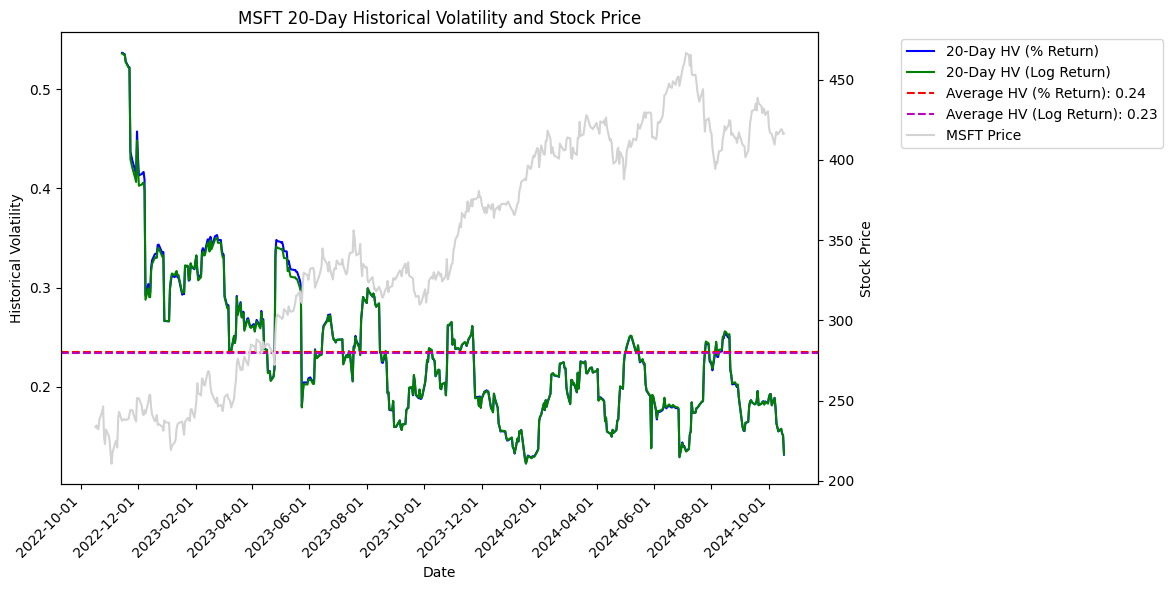

[*********************100%***********************]  1 of 1 completed


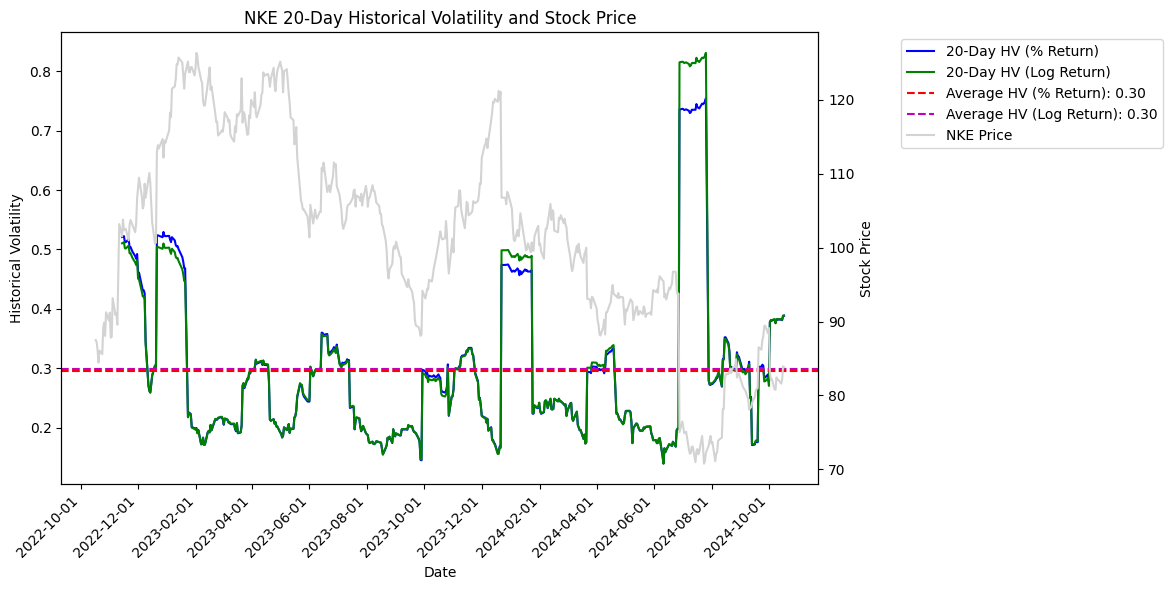

[*********************100%***********************]  1 of 1 completed


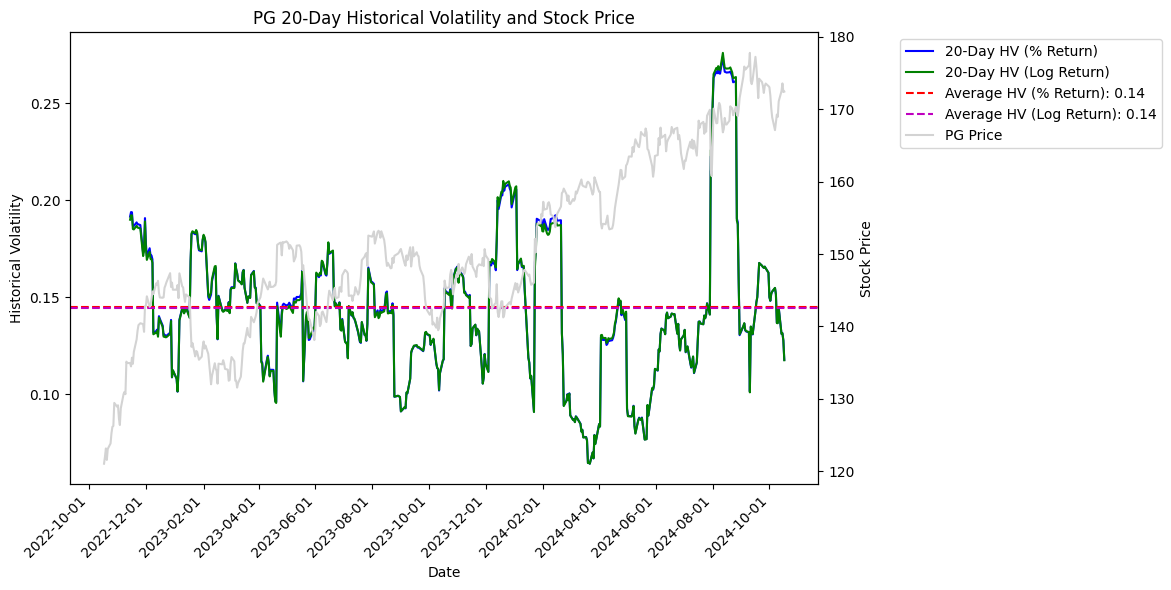

[*********************100%***********************]  1 of 1 completed


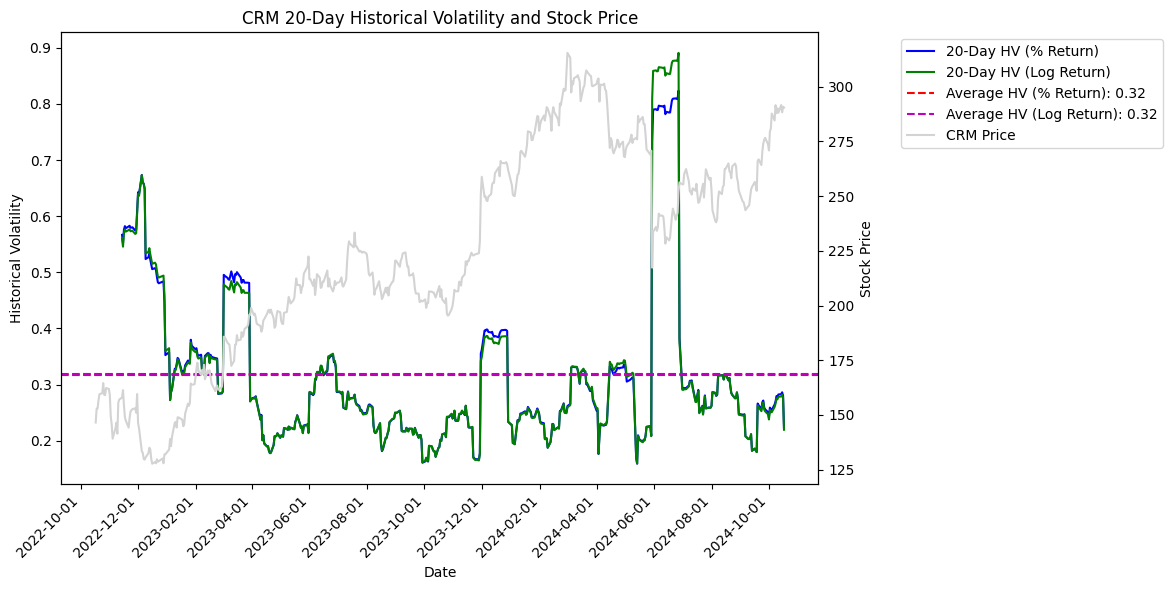

[*********************100%***********************]  1 of 1 completed


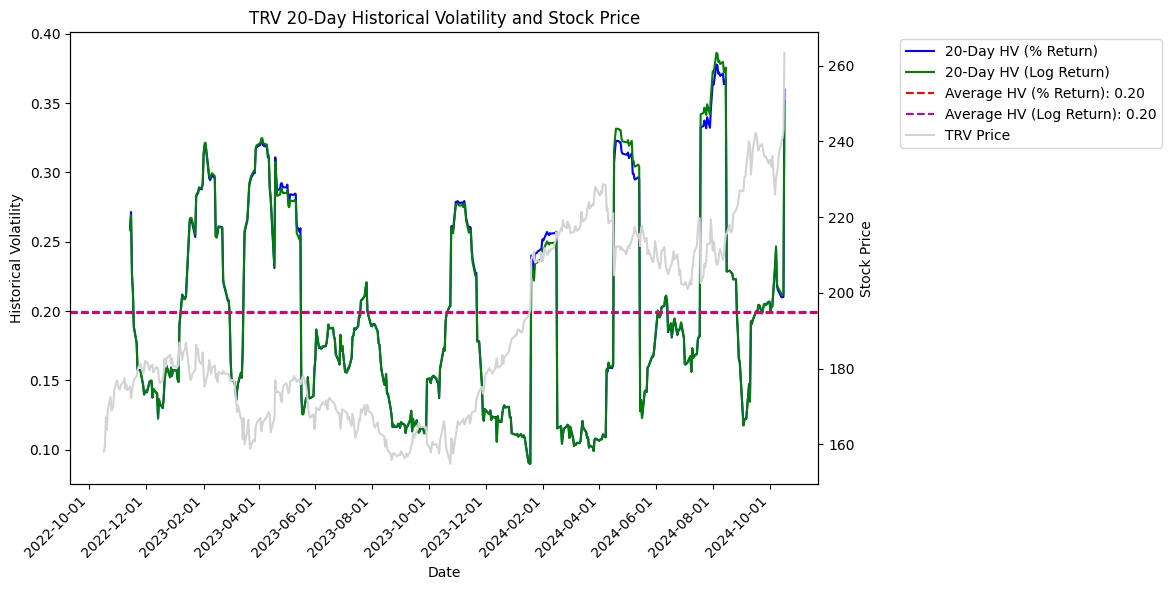

[*********************100%***********************]  1 of 1 completed


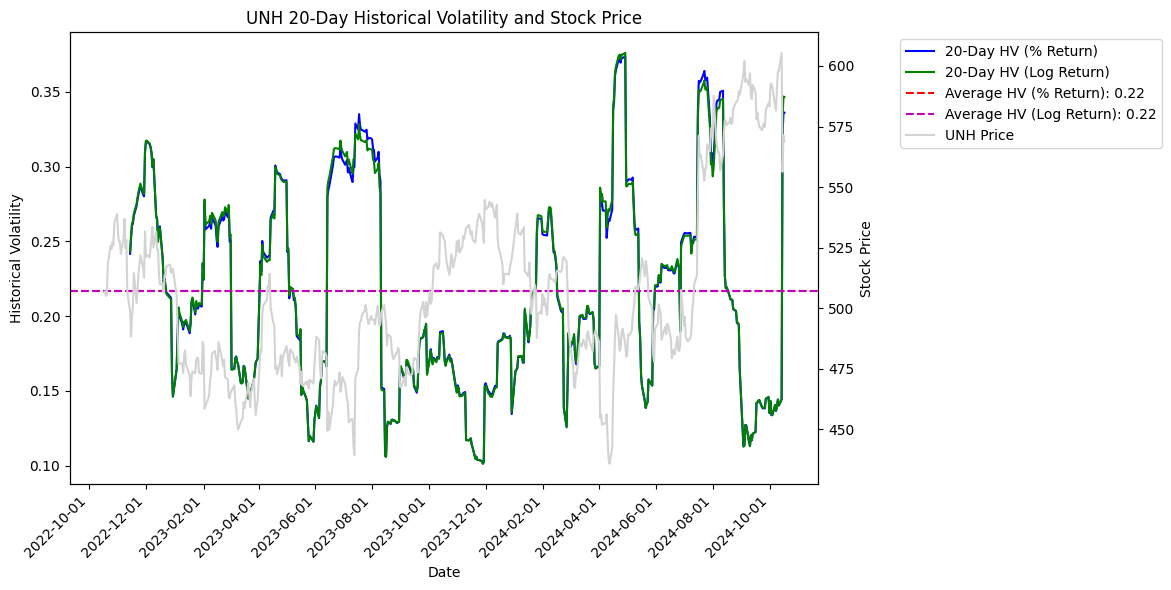

[*********************100%***********************]  1 of 1 completed


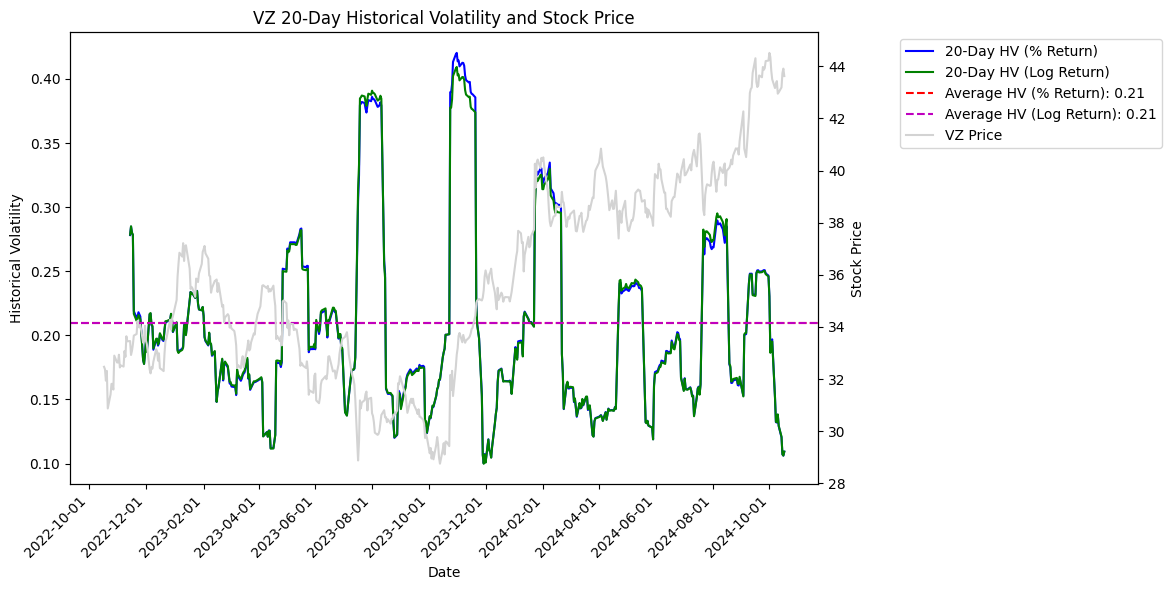

[*********************100%***********************]  1 of 1 completed


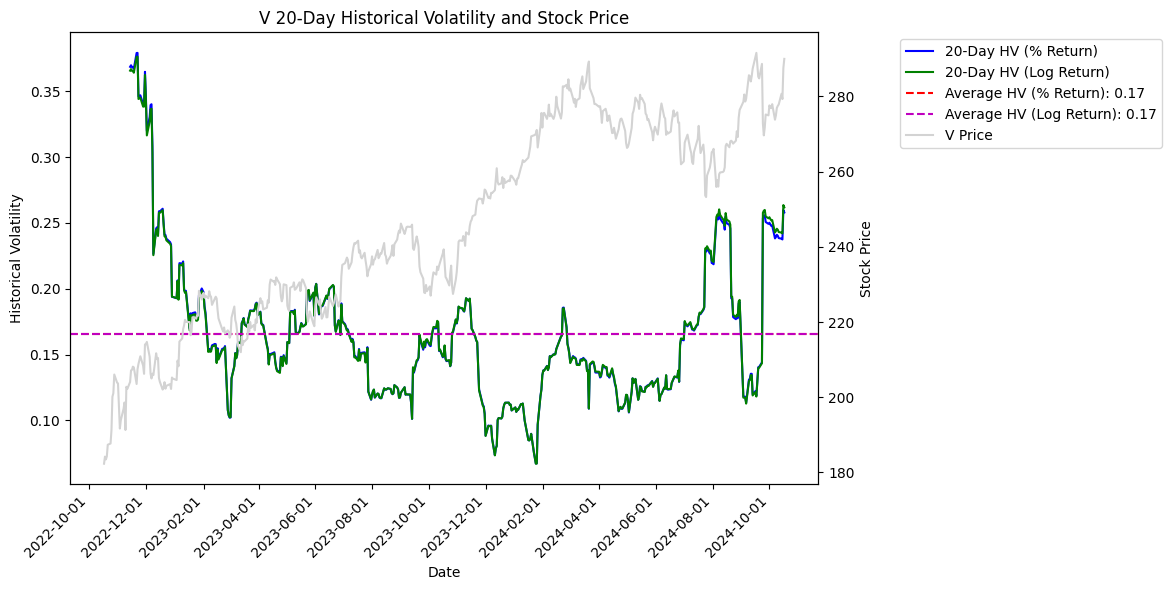

[*********************100%***********************]  1 of 1 completed


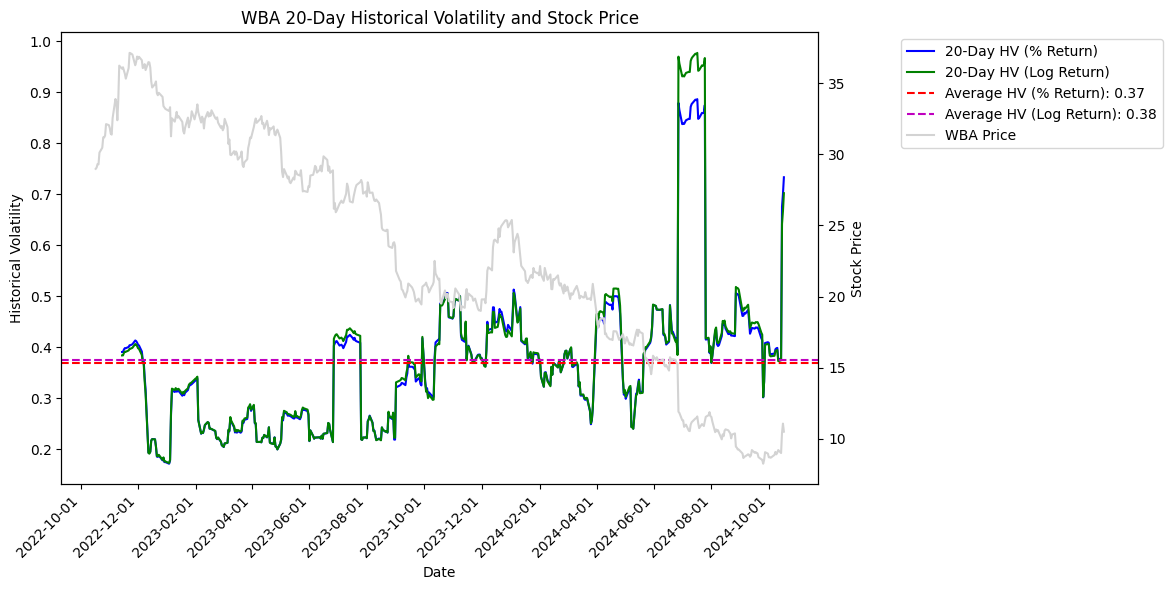

[*********************100%***********************]  1 of 1 completed


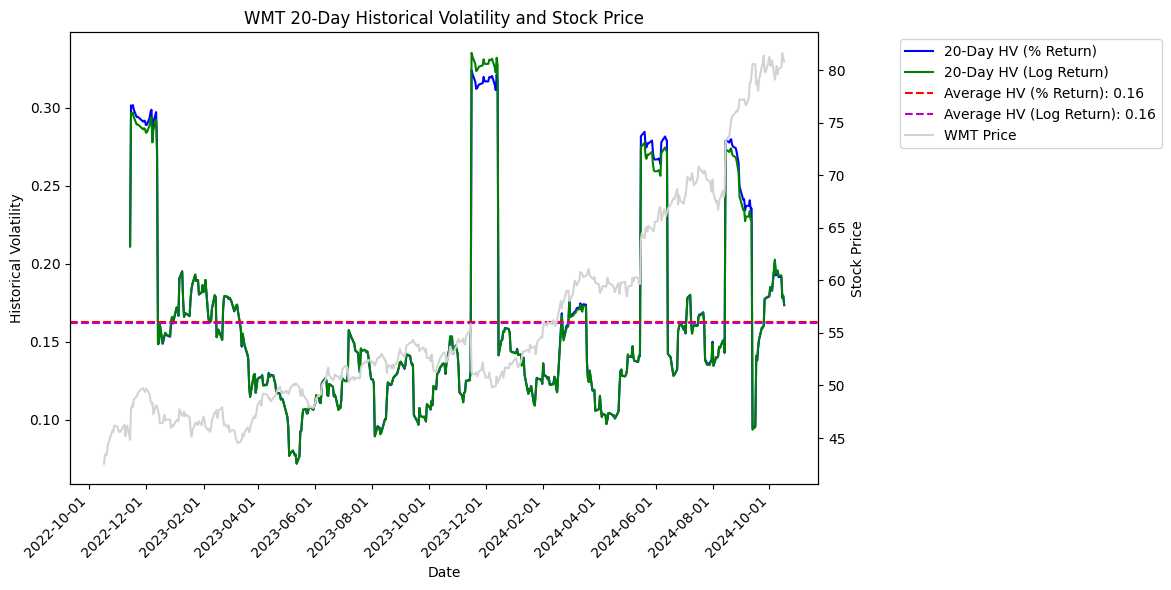

[*********************100%***********************]  1 of 1 completed


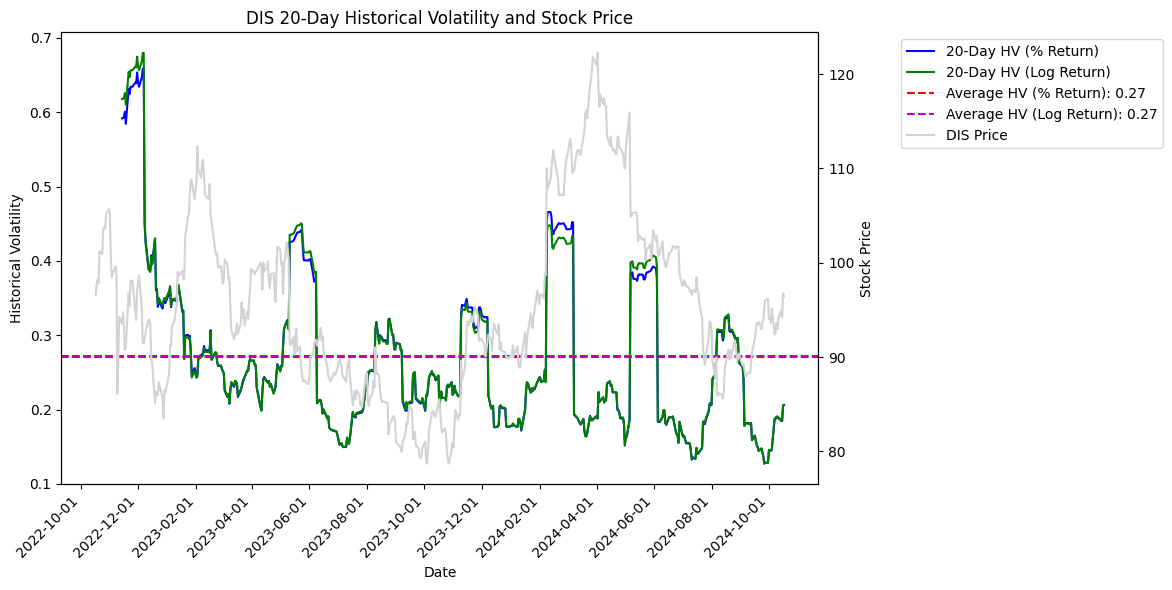

In [ ]:
import os
import shutil
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import py_vollib.black_scholes_merton.greeks.analytical as bsm_greeks
import py_vollib.black_scholes.greeks.analytical as bs_greeks
from datetime import datetime, timedelta
#Import display and HTML functions
from IPython.display import display, HTML
from tabulate import tabulate
from prettytable import PrettyTable
from termcolor import colored

######################################################################################################################################
#                         ----------------------  USER DEFINED FUNCTIONS BELOW   ---------------------------                         #
######################################################################################################################################

# Save data to CSV (debug_modeging)
def save_data_to_csv(data, filename, debug_mode=False, printFilename=False):
    # Check if the data is a dictionary
    if isinstance(data, dict):
        # Convert dictionary to DataFrame
        data = pd.DataFrame(list(data.items()), columns=['Key', 'Value'])

    # Check if the data is a DataFrame and then save
    if isinstance(data, pd.DataFrame):
        data.to_csv(filename, index=False)
        if debug_mode and printFilename:
            print(f"Saved {filename}")
    else:
        if debug_mode:
            print("Unsupported data type.")

# Function to save CSV with German localization
def save_csv_german_localized(data, filename,  debug_mode=False, printFilename=False):
    # Convert numbers to string with comma as decimal separator
    #data_localized = data.applymap(lambda x: f"{x:.4f}".replace('.', ',') if isinstance(x, (int, float)) else x)
    # Apply the function column-wise using apply
    if debug_mode:
      data_localized = data.apply(lambda col: col.map(lambda x: f"{x:.4f}".replace('.', ',') if isinstance(x, (int, float)) else x))

      # Save CSV with semicolon as the delimiter
      data_localized.to_csv(filename, sep=';', decimal=',')
      if printFilename:
        print(f"Saved localized CSV as {filename}")

# Delete the files in the directory pass as a paramater
def delete_files(dir):
  # List all files and directories in the current directory
  directory = dir
  for filename in os.listdir(directory):
      file_path = os.path.join(directory, filename)
      try:
          # Check if it's a file or directory, then delete
          if os.path.isfile(file_path) or os.path.islink(file_path):
              os.unlink(file_path)  # Delete file or link
          elif os.path.isdir(file_path):
              shutil.rmtree(file_path)  # Delete directory
      except Exception as e:
          print(f'Failed to delete {file_path}. Reason: {e}')

# Calculate the target date by adding days_to_expiration to today's date.
def calculate_target_date(days_to_expiration):
    """
    Calculate the target date by adding days_to_expiration to today's date.

    Parameters:
    days_to_expiration (int): The number of days to add to today's date.

    Returns:
    str: The target date formatted as 'YYYY-MM-DD'.
    """
    # Calculate today's date
    today = datetime.today()

    # Calculate the target date by adding days_to_expiration
    target_date = today + timedelta(days=days_to_expiration)

    # Format the target date as a string in the format 'YYYY-MM-DD'
    calculated_target_date = target_date.strftime('%Y-%m-%d')

    return calculated_target_date

# Define a function to calculate historical volatility
def calculate_hv(returns, window):
    # Calculate the rolling standard deviation of daily returns
    rolling_std = returns.rolling(window=window).std()
    # Annualize the volatility (multiply by sqrt(252))
    hv = rolling_std * np.sqrt(252)
    return hv

# Retrieve the Option Chain for a single stock
def get_Option_Chain(stock_symbol, target_date, current_stock_price):
    # Create a Ticker object
    ticker = yf.Ticker(stock_symbol)

    # Get expiration dates for the options
    expiration_dates = ticker.options
    print("\n\nget_Option_Chain- Available expiration dates:", expiration_dates)

    # Convert target_date and expiration_dates to datetime objects
    target_date = datetime.strptime(target_date, '%Y-%m-%d')
    expiration_dates_dt = [datetime.strptime(date, '%Y-%m-%d') for date in expiration_dates]

    # Find the nearest expiration date
    closest_date = min(expiration_dates_dt, key=lambda x: abs(x - target_date))
    chosen_date = closest_date.strftime('%Y-%m-%d')
    print(f"Nearest expiration date to {target_date.strftime('%Y-%m-%d')}: {chosen_date}")

    # Get the option chain for the chosen expiration date
    option_chain = ticker.option_chain(chosen_date)

    # Access calls and puts data
    calls = option_chain.calls
    puts = option_chain.puts
    # Find the first OTM call option (inTheMoney = False)
    first_otm_call = calls[calls['inTheMoney'] == False].head(1)
    # Find the first OTM put option (inTheMoney = False)
    first_itm_put = puts[puts['inTheMoney'] == True].head(1)

    return calls, puts, chosen_date, first_otm_call, first_itm_put

# Display the Option Chain for a single stock
def display_option_chain_info(calls, puts, rows_to_display):
    # Display the first few rows of calls and puts data
    print("\nCalls:")
    print(calls.head(rows_to_display))

    # Find the first OTM call option (where inTheMoney is False)
    first_otm_call = calls[calls['inTheMoney'] == False].head(1)

    # Print the first OTM call option details if available
    if not first_otm_call.empty:
        print("\nFirst OTM Call Option:")
        print(first_otm_call)
    else:
        print("\nNo OTM Call Options available.")

    print("\nPuts:")
    print(puts.head(rows_to_display))

    # Find the first ITM put option (where inTheMoney is True)
    first_itm_put = puts[puts['inTheMoney'] == True].head(1)

    # Print the first ITM put option details if available
    if not first_itm_put.empty:
        print("\nFirst ITM Put Option:")
        print(first_itm_put)
    else:
        print("\nNo ITM Put Options available.")

# Retrieve the Option Chain for multiple stocks
def get_option_chains_for_date_range(stock_symbol, target_date):
    # Create a Ticker object
    ticker = yf.Ticker(stock_symbol)

    # Get all expiration dates for the options
    expiration_dates = ticker.options
    if detailed_output:
      html_output = f"""
      <h3 style="color:#339999;"">Available expiration dates:</h3>
      """
      display(HTML(html_output))
      print(f"\t\033[1m{expiration_dates}\033[0m")

    # Convert target_date and expiration_dates to datetime objects
    target_date = datetime.strptime(target_date, '%Y-%m-%d').date()
    today = datetime.today().date()
    expiration_dates_dt = [datetime.strptime(date, '%Y-%m-%d').date() for date in expiration_dates]

    # Filter expiration dates that are between today and the target_date
    filtered_dates = [date for date in expiration_dates_dt if today <= date <= target_date]

    # Check if filtered_dates does not contain target_date_dt
    if target_date not in filtered_dates:
        # Find the next expiration date after the target_date_dt
        next_expiration_date = None
        for date in expiration_dates_dt:
            if date > target_date:
                next_expiration_date = date
                break

        # Check if filtered_dates does not contain the target_date and adjust if needed
        if target_date not in filtered_dates:
            # If there is a next expiration date, check the distances
            if next_expiration_date:
                last_filtered_date = filtered_dates[-1] if filtered_dates else None
                # Compare distances between target_date and the closest dates
                if last_filtered_date and abs((target_date - last_filtered_date).days) <= abs((next_expiration_date - target_date).days):
                    # If the target_date is closer to the last_filtered_date, don't add next_expiration_date
                    pass
                else:
                    # Otherwise, add the next expiration date
                    filtered_dates.append(next_expiration_date)

    # Sort the filtered dates to maintain order
    filtered_dates.sort()
    if detailed_output:
      html_output = f"""
      <h3 style="color:#339999;"">Targeted date:</h3>
      """
      display(HTML(html_output))
      print(f"\t\033[1m{target_date}\033[0m, Filtered expiration dates between \033[1m{today}\033[0m and \033[1m{target_date}\033[0m: \033[1m{[date.strftime('%Y-%m-%d') for date in filtered_dates]}\033[0m")

    # Dictionary to store option chain data for each expiration date
    option_chains = {}

    # Loop through each filtered expiration date and retrieve the option chain
    for date in filtered_dates:
        chosen_date = date.strftime('%Y-%m-%d')
        #print(f"Fetching option chain for expiration date: {chosen_date}")

        # Get the option chain for the chosen expiration date
        option_chain = ticker.option_chain(chosen_date)

        # Access calls and puts data
        calls = option_chain.calls
        puts = option_chain.puts

        # Store the data in the dictionary
        option_chains[chosen_date] = {'calls': calls, 'puts': puts}

    return option_chains

# Calculate the upper and lower price range based on historical volatility (HV
def calculate_price_range(current_price, hv, days=20):
    """
    Calculate the upper and lower price range based on historical volatility (HV).

    Parameters:
    - current_price: The current stock price.
    - hv: Historical volatility (annualized, expressed as a decimal).
    - days: The number of days to project (default is 20).

    Returns:
    - A tuple with (lower_range, upper_range).
    """
    # Convert HV from annualized to daily
    daily_volatility = hv / np.sqrt(252)  # 252 trading days in a year

    # Calculate the expected price range using the daily volatility
    expected_change = daily_volatility * np.sqrt(days)

    # Calculate the lower and upper bounds based on log returns
    lower_bound = current_price * np.exp(-expected_change)
    upper_bound = current_price * np.exp(expected_change)

    return lower_bound, upper_bound

# Calculates historical volatility (HV) for a given stock and saves the data to a CSV file
def calculate_and_save_hv(stock, period, time_interval,rows_to_display=5,  no_of_HV_days=20, debug_mode=False):
    """
    Calculates historical volatility (HV) for a given stock and saves the data to a CSV file.

    Parameters:
    - stock: Stock symbol (e.g., 'AAPL')
    - period: The period over which to retrieve data (e.g., '1y', '3mo')
    - time_interval: Time interval for data (e.g., '1d', '1wk')
    - rows_to_display: Number of rows to display from the DataFrame (default: 5)
    - no_of_HV_days: Number of days to calculate historical volatility (default: 20)
    - debug_mode: Boolean flag for printing debug information (default: False)

    Returns:
    - A dictionary containing the HV data, averages, and other relevant information.
    """

    hv_data = {}  # Dictionary to store HV data for each no_of_HV_days
    # Download the historical data from Yahoo Finance
    data = yf.download(stock, period=period, interval=time_interval)

    # Calculate daily returns (percentage change between consecutive close prices)
    data['Daily_Return'] = data['Adj Close'].pct_change()
    data['Daily_Return_Log'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

    # Get the stock prices for use outside the function
    stock_prices = data['Adj Close']
    # Function to calculate historical volatility (rolling standard deviation)
    def calculate_hv(returns, window):
        return returns.rolling(window=window).std() * np.sqrt(252)

    # Calculate the 'no_of_HV_days'' rolling standard deviation of daily returns (historical volatility)
    data[f'HV_{no_of_HV_days}_Day'] = calculate_hv(data['Daily_Return'], no_of_HV_days)
    data[f'HV_{no_of_HV_days}_Day_Log'] = calculate_hv(data['Daily_Return_Log'], no_of_HV_days)

    # Save data to a CSV file
    filename = f"data_{stock}_HV_Days-{no_of_HV_days}_period-{period}_{time_interval}.csv"
    data.to_csv(filename)
    if debug_mode and detailed_output:
        print(f"\nData saved to {filename}\n")

    # Drop rows with NaN values (due to rolling calculation)
    stock_hv_N_day = data[[f'HV_{no_of_HV_days}_Day', f'HV_{no_of_HV_days}_Day_Log']].dropna()

    # Store the DataFrame in the dictionary with a key based on no_of_HV_days
    hv_data[f'stock_hv_{no_of_HV_days}_day'] = data[[f'HV_{no_of_HV_days}_Day', f'HV_{no_of_HV_days}_Day_Log']].dropna()

    # Calculate the average historical volatility over the period using the dictionary
    average_hv = hv_data[f'stock_hv_{no_of_HV_days}_day'][f'HV_{no_of_HV_days}_Day'].mean()
    average_hv_Log = hv_data[f'stock_hv_{no_of_HV_days}_day'][f'HV_{no_of_HV_days}_Day_Log'].mean()

    current_stock_price = data['Adj Close'].iloc[-1]

    # Display the last # of rows, specified in 'rows_to_display' of the HV data if debug mode is on
    if debug_mode and detailed_output:
        html_output = f"""
        <h3 style="color:green; display: inline;">Historical Volatility for {no_of_HV_days} Days (Last {rows_to_display} Rows):</h3>
        """
        display(HTML(html_output))

        beautify_and_display2(hv_data[f'stock_hv_{no_of_HV_days}_day'], rows_to_display)
        #display_pretty_table(hv_data[f'stock_hv_{no_of_HV_days}_day'], rows_to_display)
        #print(hv_data[f'stock_hv_{no_of_HV_days}_day'].tail(rows_to_display))


    # Return pertinent data in a dictionary
    return {
        'current_stock_price': current_stock_price,
        f'stock_hv_{no_of_HV_days}_day': hv_data[f'stock_hv_{no_of_HV_days}_day'],
        'average_hv': average_hv,
        'average_hv_Log': average_hv_Log,
        'no_of_HV_days': no_of_HV_days,
        'filename': filename,
        'stock_prices': stock_prices
    }

# Calculate the greeks for the Option Chains
def calculate_greeks(calls, puts, current_stock_price, risk_free_rate, expiration_date, dividend_yield=0):
    # Convert the expiration date to a datetime object and calculate time to expiration in years
    today = datetime.today().date()
    expiration_date = datetime.strptime(expiration_date, '%Y-%m-%d').date()
    time_to_expiration = (expiration_date - today).days / 365.0

    # Initialize columns for Greeks in both calls and puts DataFrames
    for df in [calls, puts]:
        df['Delta'] = np.nan
        df['Gamma'] = np.nan
        df['Theta'] = np.nan
        df['Vega'] = np.nan
        df['Rho'] = np.nan

    # Select the appropriate model based on whether the stock pays dividends
    if dividend_yield > 0:
        model_greeks = bsm_greeks  # Black-Scholes-Merton
    else:
        model_greeks = bs_greeks  # Black-Scholes

    # Calculate Greeks for calls
    for index, row in calls.iterrows():
        S = current_stock_price
        K = row['strike']
        T = time_to_expiration
        r = risk_free_rate
        sigma = row['impliedVolatility']

        # Check if sigma is valid and above a minimum threshold
        if np.isnan(sigma) or sigma <= 0:
            continue  # Skip this row if sigma is not valid

        # Avoid division errors in the model by ensuring sigma is not too small
        sigma = max(sigma, 1e-6)

        if dividend_yield > 0:
            # Using Black-Scholes-Merton model (requires dividend yield)
            calls.at[index, 'Delta'] = bsm_greeks.delta('c', S, K, T, r, sigma, dividend_yield)
            calls.at[index, 'Gamma'] = bsm_greeks.gamma('c', S, K, T, r, sigma, dividend_yield)
            calls.at[index, 'Theta'] = bsm_greeks.theta('c', S, K, T, r, sigma, dividend_yield)
            calls.at[index, 'Vega'] = bsm_greeks.vega('c', S, K, T, r, sigma, dividend_yield)
            calls.at[index, 'Rho'] = bsm_greeks.rho('c', S, K, T, r, sigma, dividend_yield)
        else:
            # Using Black-Scholes model (does not require dividend yield)
            calls.at[index, 'Delta'] = bs_greeks.delta('c', S, K, T, r, sigma)
            calls.at[index, 'Gamma'] = bs_greeks.gamma('c', S, K, T, r, sigma)
            calls.at[index, 'Theta'] = bs_greeks.theta('c', S, K, T, r, sigma)
            calls.at[index, 'Vega'] = bs_greeks.vega('c', S, K, T, r, sigma)
            calls.at[index, 'Rho'] = bs_greeks.rho('c', S, K, T, r, sigma)

    # Calculate Greeks for puts
    for index, row in puts.iterrows():
        S = current_stock_price
        K = row['strike']
        T = time_to_expiration
        r = risk_free_rate
        sigma = row['impliedVolatility']

        # Check if sigma is valid and above a minimum threshold
        if np.isnan(sigma) or sigma <= 0:
            continue  # Skip this row if sigma is not valid

        # Avoid division errors in the model by ensuring sigma is not too small
        sigma = max(sigma, 1e-6)

        if dividend_yield > 0:
            puts.at[index, 'Delta'] = bsm_greeks.delta('p', S, K, T, r, sigma, dividend_yield)
            puts.at[index, 'Gamma'] = bsm_greeks.gamma('p', S, K, T, r, sigma, dividend_yield)
            puts.at[index, 'Theta'] = bsm_greeks.theta('p', S, K, T, r, sigma, dividend_yield)
            puts.at[index, 'Vega'] = bsm_greeks.vega('p', S, K, T, r, sigma, dividend_yield)
            puts.at[index, 'Rho'] = bsm_greeks.rho('p', S, K, T, r, sigma, dividend_yield)
        else:
            puts.at[index, 'Delta'] = bs_greeks.delta('p', S, K, T, r, sigma)
            puts.at[index, 'Gamma'] = bs_greeks.gamma('p', S, K, T, r, sigma)
            puts.at[index, 'Theta'] = bs_greeks.theta('p', S, K, T, r, sigma)
            puts.at[index, 'Vega'] = bs_greeks.vega('p', S, K, T, r, sigma)
            puts.at[index, 'Rho'] = bs_greeks.rho('p', S, K, T, r, sigma)

    # Convert all Greek columns in both DataFrames to float (decimal values)
    greek_columns = ['Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
    for df in [calls, puts]:
        for col in greek_columns:
            df[col] = df[col].astype(float)

    # Return the calls and puts DataFrames with Greeks and other specified columns
    return calls[['strike', 'bid', 'ask', 'lastPrice', 'volume', 'openInterest', 'inTheMoney', 'impliedVolatility', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']], \
           puts[['strike', 'bid', 'ask', 'lastPrice', 'volume', 'openInterest', 'inTheMoney', 'impliedVolatility','Delta', 'Gamma', 'Theta', 'Vega', 'Rho']]

# Plots the historical volatility for the given stock data
def plot_historical_volatility(stock_hv_N_day, no_of_HV_days, average_hv, average_hv_Log, stock, stock_prices):
    """
    Plots the historical volatility and stock price for the given stock data.

    Parameters:
    - stock_hv_N_day: DataFrame containing historical volatility data.
    - no_of_HV_days: Number of days for the rolling window (e.g., 20 for 20-day HV).
    - average_hv: Average historical volatility calculated using percentage returns.
    - average_hv_Log: Average historical volatility calculated using log returns.
    - stock: The stock symbol or name.
    - stock_prices: Series containing the stock prices indexed by date.
    """

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot the historical volatility
    ax1.plot(stock_hv_N_day.index, stock_hv_N_day[f'HV_{no_of_HV_days}_Day'], label=f'{no_of_HV_days}-Day HV (% Return)', color='b')
    ax1.plot(stock_hv_N_day.index, stock_hv_N_day[f'HV_{no_of_HV_days}_Day_Log'], label=f'{no_of_HV_days}-Day HV (Log Return)', color='g')

    # Add horizontal lines for the average HV
    ax1.axhline(y=average_hv, color='r', linestyle='--', label=f'Average HV (% Return): {average_hv:.2f}')
    ax1.axhline(y=average_hv_Log, color='m', linestyle='--', label=f'Average HV (Log Return): {average_hv_Log:.2f}')

    # Set labels and title for the primary y-axis (HV)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Historical Volatility')
    ax1.set_title(f'{stock} {no_of_HV_days}-Day Historical Volatility and Stock Price')

    # Create a secondary y-axis for the stock price
    ax2 = ax1.twinx()
    ax2.plot(stock_prices.index, stock_prices, label=f'{stock} Price', color='lightgrey')
    ax2.set_ylabel('Stock Price')

    # Combine legends for both y-axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1.1, 1))

    # Set the date format, major ticks to every 2 month, and rotate x-axis labels
    # Set s
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format dates
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # Rotate x-axis labels and adjust layout
    #plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Define a function to print the colored table
def print_coloredA_volatility_differences(all_volatility_differences):
    table = PrettyTable()

    # Define the column names with some color using ANSI escape codes
    table.field_names = [
        "\033[1;34mStock\033[0m",  # Bold blue
        "\033[1;32mDate\033[0m",   # Bold green
        "\033[1;33mFirst OTM IV\033[0m",  # Bold yellow
        "\033[1;33mLast ITM IV\033[0m",   # Bold yellow
        "\033[1;35mCurrent HV N Day Log\033[0m",  # Bold magenta
        "\033[1;36mVolatility Difference (%)\033[0m"  # Bold cyan
    ]

    # Set the table style
    table.hrules = True  # Enable horizontal rules
    table.vrules = True  # Enable vertical rules
    table.border = True   # Enable the outer border
    table.padding_width = 1  # Padding between columns

    # Add rows to the table
    for entry in all_volatility_differences:
        table.add_row([
            entry['stock'],
            entry['date'],
            f"{entry['first_otm_iv']:.6f}",
            f"{entry['last_itm_iv']:.6f}",
            f"{entry['current_HV_N_day_Log']:.6f}",
            f"{entry['hv_difference']:.2f}"
        ])

    print("\nAll Volatility Differences:")
    print(table)

# Function to create a colored HTML table
def print_colored_volatility_differences(all_volatility_differences):
    # Define the table header
    headers = ["Stock", "Date", "First OTM IV", "Last ITM IV", "Current HV N Day Log", "Volatility Difference (%)"]

    # Start building the HTML table
    html = '<table style="border-collapse: collapse; width: auto;">'
    html += '<thead><tr>'

    # Add header row with colors
    for header in headers:
        html += f'<th style="background-color: #f2f2f2; color: black; padding: 5px; text-align: left; border: 1px solid #dddddd; font-weight: bold;">{header}</th>'
    html += '</tr></thead><tbody>'

    # Add data rows with colors
    for entry in all_volatility_differences:
        html += '<tr>'
        html += f'<td style="color: green; padding: 5px; border: 1px solid #dddddd; width: 80px;">{entry["stock"]}</td>'
        html += f'<td style="color: #339999; padding: 5px; border: 1px solid #dddddd; width: 120px;">{entry["date"]}</td>'
        html += f'<td style="color: #339999; padding: 5px; border: 1px solid #dddddd; width: 100px;">{entry["first_otm_iv"]:.6f}</td>'
        html += f'<td style="color: #339999; padding: 5px; border: 1px solid #dddddd; width: 100px;">{entry["last_itm_iv"]:.6f}</td>'
        html += f'<td style="color: #339999; padding: 5px; border: 1px solid #dddddd; width: 100px;">{entry["current_HV_N_day_Log"]:.6f}</td>'
        html += f'<td style="color: magenta; padding: 5px; border: 1px solid #dddddd; width: 120px;">{entry["volatility_difference"]:.2f}</td>'
        html += '</tr>'

    html += '</tbody></table>'

    # Display the HTML table
    display(HTML(html))

# Function to display a pretty table
def display_pretty_table(data, rows_to_display):
    table = PrettyTable()
    # Add the index (date) as the first column
    table.field_names = ['Date'] + data.columns.tolist()

    for index, row in data.tail(rows_to_display).iterrows():
        # Format the date and the float values
        date_str = index.strftime('%Y-%m-%d')  # Format the date
        formatted_row = [f"{value:.6f}" if isinstance(value, float) else value for value in row.values]
        table.add_row([date_str] + formatted_row)

    print(table)

# Function to beautify and display filtered calls and puts
def beautify_and_display(df, rows_to_display):
    if not df.empty:
        # Reset index to include it in the display
        df = df.reset_index()
        # Convert the DataFrame to a list of lists for tabulate
        df = df.head(rows_to_display)
        headers = df.columns.tolist()

        # Prepare data for tabulate
        table_data = df.values.tolist()

        # Use tabulate to display the table
        print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))
    else:
        print(f"Filtered Data - No data available")

# Function to beautify and display a dataFrame
def beautify_and_display2(data, rows_to_display=5):
    # Convert the date column if it is the index
    if isinstance(data.index, pd.DatetimeIndex):
        data = data.copy()
        data.index = data.index.strftime('%Y-%m-%d')

    styled_data = (
        data.tail(rows_to_display)
        .style.set_table_styles(
            [{'selector': 'thead th', 'props': [('background-color', '#f0f0f0'), ('color', 'black')]}]
        )
        .format({
            col: "{:.6f}" for col in data.select_dtypes(include='float').columns
        })
        .set_properties(**{'text-align': 'center'})
    )

    display(styled_data)


######################################################################################################################################
# ----------------------                      END OF USER DEFINED FUNCTIONS                                    --------------------- #
######################################################################################################################################

#delete any old data before starting
delete_files('/content/')

# Toggle for debug_modeging purposes
debug_mode = False
data = None   #Clear data before starting

# Flag to control detailed output
detailed_output = False  # Set to True if you want to see detailed tables and data

"""
# Define the stock symbol
# List of popular stocks
 stocks = ['SHOP', 'MSFT', 'GOOG', 'AMZN', 'INTC', 'META', 'NVDA', 'MU', 'AAPL', 'PLTR', 'IBM', 'AMD', 'NFLX',
    'UBER', 'EBAY', 'QCOM', 'AVGO', 'PYPL', 'CRM', 'TSLA', 'T', 'COIN', 'ORCL',
   'BA', 'CAT', 'GE', 'F', 'GM',
    'BAC', 'C', 'JPM', 'V', 'MA', 'AXP',
    'WMT', 'PG', 'KO', 'NKE', 'MCD', 'SBUX',
    'JNJ'
]
"""

#stocks = ["GLW"]
stocks = ['MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WBA', 'WMT', 'DIS' ]
#stocks = ['SHOP', 'MSFT', 'GOOG', 'AMZN', 'INTC', 'META', 'NVDA', 'MU', 'AAPL', 'PLTR', 'IBM', 'AMD', 'NFLX']
period = '2y'
time_interval = '1d'
rows_to_display = 35
no_of_HV_days = 20
risk_free_rate = 0.05
days_to_expiration = 45
lower_delta_range = .14
higher_delta_range = .70

calculated_target_date = calculate_target_date(days_to_expiration)
if detailed_output:
    html_output = f"""
    <h2 style="color:#CC0099;">#####################  OPTION TRADING STRATEGY FOR STOCK: {stocks} ####################</h2>
    <h3 style="color:#339999;"">Parameters specified:</h3>
    <ul>
        <li><strong style="color:#339999;">stock_tickers:</strong> {stocks}</li>
        <li><strong style="color:#339999;">time_interval:</strong> {time_interval}</li>
        <li><strong style="color:#339999;">period:</strong> {period}</li>
        <li><strong style="color:#339999;">rows_to_display:</strong> {rows_to_display}</li>
        <li><strong style="color:#339999;">no_of_HV_days:</strong> {no_of_HV_days}</li>
        <li><strong style="color:#339999;">risk_free_rate:</strong> {risk_free_rate}</li>
        <li><strong style="color:#339999;">days_to_expiration:</strong> {days_to_expiration}</li>
        <li><strong style="color:#339999;">lower_delta_range:</strong> {lower_delta_range}</li>
        <li><strong style="color:#339999;">higher_delta_range:</strong> {higher_delta_range}</li>
    </ul>
    <h3 style="color:green; display: inline;">Calculated target date:</h3>
    <span style="color:#339999;""> <strong>{calculated_target_date}</strong></span>
    """
    display(HTML(html_output))
    #print("\nCalculated target date:", calculated_target_date)

# List to store HV differences for all stocks
all_volatility_differences = []

# Iterate over each stock symbol in the list
for stock in stocks:
    if detailed_output:
        html_output = f"""
        <h2 style="color:#CC0099;">#####################  PROCESSING STOCK: {stock}  ####################</h2>.
        """
        display(HTML(html_output))

    # Calculate the historical value data, given the below parameters
    hv_data = calculate_and_save_hv(stock, period, time_interval, no_of_HV_days=no_of_HV_days, debug_mode=True)

    # Access returned data
    average_hv = hv_data['average_hv']
    average_hv_Log = hv_data['average_hv_Log']
    stock_hv_N_day = hv_data[f'stock_hv_{no_of_HV_days}_day']
    current_stock_price = hv_data['current_stock_price']
    no_of_HV_days= hv_data['no_of_HV_days']
    stock_prices = hv_data['stock_prices']

    if not detailed_output:
        plot_historical_volatility(stock_hv_N_day, no_of_HV_days, average_hv, average_hv_Log, stock, stock_prices)

                        ####################################################################################################################
                        #############################################   GET OPTION CHAIN LOGIC    ##########################################
                        ####################################################################################################################

    # Retrieve Option Chain data

    # Call the get_Option_Chain function and store the return values
    #calls, puts, chosen_date, first_otm_call, first_itm_put = get_Option_Chain(stock, calculated_target_date, current_stock_price)
    #display_option_chain_info(calls, puts, rows_to_display)

    # Calculate the Greeks for both calls and puts
    #calls_with_greeks, puts_with_greeks = calculate_greeks(calls, puts, current_stock_price, risk_free_rate, chosen_date, 0)

    #print(f"\nCalls with Greeks for stock: {stock}, current_stock_price: {current_stock_price:.4f}:")
    #print(calls_with_greeks[['strike', 'lastPrice', 'bid', 'ask', 'volume', 'openInterest', 'impliedVolatility', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']].head(rows_to_display))
    #filename = f"calls_with_greeks_{stock}_{current_stock_price:.4f}_{risk_free_rate}_{chosen_date}.csv"
    #save_data_to_csv(calls_with_greeks, filename, debug_mode)
    #print(f"\nPuts with Greeks for stock: {stock}, current_stock_price: {current_stock_price:.4f}:")
    #print(puts_with_greeks[['strike', 'lastPrice', 'bid', 'ask', 'volume', 'openInterest', 'impliedVolatility', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']].head(rows_to_display))
    #filename = f"puts_with_greeks_{stock}_{current_stock_price:.4f}_{risk_free_rate}_{chosen_date}.csv"
    #save_data_to_csv(puts_with_greeks, filename, debug_mode)

    # Get the most recent closing price from the downloaded data
    current_HV_N_day = stock_hv_N_day.iloc[-1][f'HV_{no_of_HV_days}_Day']
    current_HV_N_day_Log = stock_hv_N_day.iloc[-1][f'HV_{no_of_HV_days}_Day_Log']

    # Call the function to calculate the price range for the next 20 days
    lower_range, upper_range = calculate_price_range(current_stock_price, current_HV_N_day_Log)

    if detailed_output:
      html_output = f"""
      <h3 style="color:#339999;"">HV Calulated variables:</h3>
      <ul>
          <li><strong style="color:#339999;">Current Stock Price: </strong><span><strong>{current_stock_price:.4f}</strong></span></li>
          <li><strong style="color:#339999;">Current HV_N_Day, where N is '{no_of_HV_days}' days: </strong><span><strong>{current_HV_N_day:.6f}</strong></span></li>
          <li><strong style="color:#339999;">Current HV_N_Day_Log, where N is '{no_of_HV_days}' days: </strong><span><strong>{current_HV_N_day_Log:.6f}</strong></span></li>
          <li><strong style="color:#339999;">Number of days to calculate historical volatility: </strong><span><strong>{no_of_HV_days}</strong></span></li>
          <li><strong style="color:#339999;">Average {no_of_HV_days}-Day HV: </strong><span><strong>{average_hv}</strong></span></li>
          <li><strong style="color:#339999;">Average {no_of_HV_days}-Day Log HV: </strong><span><strong>{average_hv_Log}</strong></span></li>
          <li><strong style="color:#339999;">Rows to display: </strong><span><strong>{rows_to_display}</strong></span></li>
          <li><strong style="color:#339999;">{no_of_HV_days}-Day Projected Lower Range: </strong><span><strong>{lower_range}</strong></span></li>
          <li><strong style="color:#339999;">{no_of_HV_days}-Day Projected Upper Range: </strong><span><strong>{upper_range}</strong></span></li>
      </ul>
      """
      display(HTML(html_output))
      #print(f"\n\nCurrent Stock Price: {current_stock_price:.4f}")
      #print(f"Current HV_N_Day, where N is '{no_of_HV_days}' days: {current_HV_N_day}")
      #print(f"Current HV_N_Day_Log, where N is '{no_of_HV_days}' days: {current_HV_N_day_Log}")

      #print(f"Number of days to calculate historical volatility: {no_of_HV_days}")
      #print(f"Average {no_of_HV_days}-Day HV: {average_hv}")
      #print(f"Average {no_of_HV_days}-Day Log HV: {average_hv_Log}")
      #print(f"Rows to display: {rows_to_display}")
      #print(f"{no_of_HV_days}-Day Projected Lower Range: {lower_range}")
      #print(f"{no_of_HV_days}-Day Projected Upper Range: {upper_range}")

    # Set Pandas display options to show all columns without breaking
    # Set display options for Pandas
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.width', 1000)        # Adjust the display width
    pd.set_option('display.max_colwidth', None) # Ensure all column values are fully displayed

    # Get Option chain data for a specific date range, where range is between today and target_date
    option_chains = get_option_chains_for_date_range(stock, calculated_target_date)

    # Access option data for a specific expiration date
    stock_volatility_differences = []  # List to store HV differences for the last date
    # Set pandas to display float values with 4 decimal places (adjust as needed)
    pd.set_option('display.float_format', '{:.6f}'.format)

    # Iterate over the option chains, processing each date's data
    for idx, (date, option_data) in enumerate(option_chains.items()):
        option_data['calls'], option_data['puts'] = calculate_greeks(option_data['calls'], option_data['puts'], current_stock_price, risk_free_rate, calculated_target_date, 0)
        # Filter calls where Delta is between 0.15 and 0.70
        filtered_calls = option_data['calls'][(option_data['calls']['Delta'] >= lower_delta_range) & (option_data['calls']['Delta'] <= higher_delta_range)]
        #print(f"{filtered_calls}")

        # Find the first OTM call option (where inTheMoney is False)
        first_otm_call = filtered_calls[filtered_calls['inTheMoney'] == False].head(1)
        first_otm_iv = None
        last_itm_iv = None
        volatility_difference_percentage = None
        if detailed_output:
            html_output = f"""
            <h2 style="color:#CC0099;">&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *</h2>
            <h2 style="color:#339999;"">Date: {date}, stock: {stock}</h2>
            """
            display(HTML(html_output))
            #print(f"\n\nDate: {date}")
        if not first_otm_call.empty:
            first_otm_index = first_otm_call.index[0]
            # Find the last ITM call (the row right before the first OTM call)
            last_itm_call = filtered_calls[(filtered_calls['inTheMoney'] == True) & (filtered_calls.index <= first_otm_index - 1)].tail(1)
            if detailed_output:
                html_output = f"""
                <h3 style="color:#339999;"">Calls:</h3>
                """
                display(HTML(html_output))

                print(f"\tFirst OTM call: Strike - \033[1m{first_otm_call['strike'].values[0]}\033[0m, first_otm_iv: \033[1m{first_otm_call['impliedVolatility'].values[0]:.6f}\033[0m")

            # Only try to access 'last_itm_call' values if it's not empty
            if not last_itm_call.empty:
                # Calculate the average of the IVs for the first OTM call and the last ITM call
                first_otm_iv = first_otm_call['impliedVolatility'].values[0]
                last_itm_iv = last_itm_call['impliedVolatility'].values[0]
                avg_iv = (first_otm_iv + last_itm_iv) / 2

                # Calculate the difference between current HV and avg IV, divided by current_HV_N_day_Log
                volatility_difference = (avg_iv) / current_HV_N_day_Log
                volatility_difference_percentage = volatility_difference * 100
                if detailed_output:
                  print(f"\tAverage IV: \033[1m{avg_iv:.6f}\033[0m, current_HV_N_day_Log: \033[1m{current_HV_N_day_Log:.6f}\033[0m")
                  print(f"\tVolatility Difference (adjusted by current_HV_N_day_Log): \033[1m{volatility_difference_percentage:.2f}%\033[0m")

                # If this is the last date, store the volatility_difference along with the date
                if idx == len(option_chains) - 1:
                    stock_volatility_differences.append({
                        'stock': stock,
                        'date': date,
                        'first_otm_iv': first_otm_iv,
                        'last_itm_iv': last_itm_iv,
                        'current_HV_N_day_Log': current_HV_N_day_Log,
                        'volatility_difference': volatility_difference_percentage
                    })

                if detailed_output:
                    print(f"\tLast ITM Call: Strike = \033[1m{last_itm_call['strike'].values[0]}\033[0m, last_itm_iv: \033[1m{last_itm_call['impliedVolatility'].values[0]:.6f}\033[0m\n")
            else:
                if detailed_output:
                    print(f"\tNo ITM calls available within the Delta range of {lower_delta_range} to {higher_delta_range}\n")
        else:
            if detailed_output:
                print(f"\nDate: {date}, No OTM call options available within the Delta range of {lower_delta_range} to {higher_delta_range}\n")

        # Beautify and display filtered calls
        if detailed_output:
          beautify_and_display(filtered_calls, rows_to_display=rows_to_display)

        # Filter puts where Delta is between 0.15 and 0.70
        filtered_puts = option_data['puts'][(option_data['puts']['Delta'] <= -lower_delta_range) & (option_data['puts']['Delta'] >= -higher_delta_range)]
        #print(f"{option_data['puts']}")
        first_itm_put =  filtered_puts[filtered_puts['inTheMoney'] == True].head(1)
        if not first_itm_put.empty:
            if detailed_output:
                html_output = f"""
                <h2 style="color:#339999;"">Puts:</h2>
                """
                display(HTML(html_output))
                print(f"\tFirst ITM put: \033[1m{first_itm_put['strike'].values[0]}\033[0m")
        else:
            if detailed_output:
                print(f"\nDate: {date}, No ITM puts available within the Delta range of -{lower_delta_range} to -{higher_delta_range}\n")

        # Beautify and display filtered puts
        if detailed_output:
          beautify_and_display(filtered_puts, rows_to_display=rows_to_display)
        #print(filtered_puts.head(rows_to_display))

    # Append the stock-specific HV differences to the global list
    all_volatility_differences.extend(stock_volatility_differences)

    # Reset options to default (optional, for other prints later)
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')

    filename = f"option_chains_{stock}_{calculated_target_date}.csv"
    save_data_to_csv(option_chains, filename, debug_mode)
    if detailed_output:
      for entry in stock_volatility_differences:
          print(f"Volatility Difference for \033[1m{entry['stock']}\033[0m] for the \033[1mCALL\033[0m options expiring: \033[1m{entry['date']}\033[0m")
          print(f"\tFirst OTM IV: \033[1m{entry['first_otm_iv']:.6f}\033[0m, Lasst ITM IV: \033[1m{entry['last_itm_iv']:.6f}\033[0m")
          print(f"\tCurrent HV for \033[1m{no_of_HV_days}\033[0m days: \033[1m{entry['current_HV_N_day_Log']}\033[0m")
          print(f"\tVolatility Difference: \033[1m{entry['volatility_difference']:.2f}%\033[0m")
    if detailed_output:
      html_output = f"""
      <h2 style="color:#CC0099;">{'&nbsp;' * 30}{'#' * 90}</h2>
      """
      display(HTML(html_output))

# Beautify the output of all HV differences
#print("\nAll Volatility Differences:")
html_output = f"""
<h2 style="color:#CC0099;">All Volatility Differences:</h2>.
"""
display(HTML(html_output))
# Call the function to print the colored table
print_colored_volatility_differences(all_volatility_differences)